## Preamble

In [4]:
import numpy as np

import scipy as sp
import scipy.stats as stats
from scipy.stats import linregress,t
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import rc
plt.rc('text', usetex=True)
font = {'family' : 'serif',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('ytick', labelsize=32) 
plt.rc('xtick', labelsize=32)
plt.rc('text.latex', preamble=r'\usepackage{color}')

import json

import os
import math
from tqdm import tqdm

import pandas as pd

In [5]:
# Plotting color
Sham = True
ColLS = True
C = np.array([[166,206,227],
[31,120,180],
[178,223,138],
[51,160,44],
[251,154,153],
[227,26,28],
[253,191,111],
[255,127,0],
[202,178,214],
[106,61,154],
[255,255,153],
            [169,169,169],
             [128,128,128]])
C = C/255.
ColorDict = {'mean':0,'median':1,'Control': 1,'CamKII':3,'Calcineurin':7,'CHX':5,'Anisomycin':9,'Sham':-1,'CamKII_alt':3,'CHX_alt':5,}

labelDict = {'CamKII':'AIP','Calcineurin':'FK506','Control':'Control','Sham':'Sham','CHX':'CHX','Anisomycin':'Anisomycin'}

spineplot = np.arange(1,16,0.5)
lw    = 4
fs    = 20

Fulltimes = [-15,-10,-5,2,10,20,30,40]

tmin    =  0
tmax    =  40
tpts    =  tmax*1000+1
dt     = (tmax-tmin)/tpts
tvec  = np.linspace(tmin,tmax,tpts)

DatDir = './DataProcessed/'

In [6]:
def PreSortData(RealDat,Flag):
    
    Pot = []
    for i,d in enumerate(RealDat):
        if(abs((d[3]-d[:3].mean())/d[:3].std())>1.96 and d[3]-d[:3].mean()>0):
            Pot.append(Flag)
        else:
            Pot.append(not Flag)
    return np.delete(RealDat,Pot,axis=0)

def PreSortData2(RealDat,Flag):
    
    Pot = []
    for i,d in enumerate(RealDat):
        if(abs((d[3]-d[:3].mean())/d[:3].std())>1.96 and d[3]-d[:3].mean()>0):
            Pot.append(Flag)
        else:
            Pot.append(not Flag)
    return np.delete(RealDat,Pot,axis=0),Pot

def LoadOneSpine(Dir,Filter=True):

    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            pass
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(m)
        lmeans.append(lm)
    dists = np.array(dists)
    means = np.array(means)
    lmeans = np.array(lmeans)
    means = np.squeeze(means)
    lmeans = np.squeeze(lmeans)
    means = means-lmeans
    
    if(Filter):
        meansS = PreSortData(means,False)
    else:
        meansS = means
    meansS = (meansS.T/(meansS[:,:3].mean(axis=-1)))
    
    return meansS

def LoadSevenSpine(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))

    middle = [np.array(m)[np.argsort(d)[3]] for m,d in zip(means,dists)]
    middleS = np.vstack(middle).squeeze()
    
    extreme = [np.array(m)[np.argsort(d)[[0,-1]]] for m,d in zip(means,dists)]
    extremeS = np.vstack(extreme).squeeze()
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))
    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],[np.array(d)-min(d) for d in dists]

def LoadSevenSpine2(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            pass
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))

    middle = [np.array(m)[np.argsort(d)[[2,3,4]]] for m,d in zip(means,dists)]
    middleS = np.vstack(middle).squeeze()
    
    extreme = [np.array(m)[np.argsort(d)[[0,1,-2,-1]]] for m,d in zip(means,dists)]
    extremeS = np.vstack(extreme).squeeze()
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))
    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],[np.array(d)-min(d) for d in dists]

def LoadSevenSpine3(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))
    means = np.vstack(means).squeeze()
    meansS = (means.T/(means[:,:3].mean(axis=-1))).T
    if(Flag):
        meansS,p = PreSortData2(meansS,False)
    
    return np.array(meansS),[np.array(d) for d in dists],p


def LoadThreeSpine(Dir,Flag):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)

    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(m)
        lmeans.append(lm)
    dists = np.array(dists)
    means = np.array(means)
    lmeans = np.array(lmeans)

    means = np.squeeze(means)
    lmeans = np.squeeze(lmeans)
    means = means-lmeans
    
    middle = [means[i,np.argsort(dists,axis=1)[i,1]] for i in range(7)]
    lower = [means[i,np.argsort(dists,axis=1)[i,0]] for i in range(7)]
    upper = [means[i,np.argsort(dists,axis=1)[i,2]] for i in range(7)]
    middleS = np.array(middle)
    extremeS = np.vstack([lower,upper])
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))

    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],(dists.T-dists.min(axis=-1)).T

def Load15Spine(Dir,Flag=True):
    Syn_a_arr = []
    for d in tqdm(os.listdir(Dir)):
        try:
            with open(Dir+d+'/Spine/Synapse_l.json', 'r') as fp: Syn_a_arr.append(json.load(fp))
        except Exception as e:
            print(e)
            
    dists = []
    means = []
    lmeans = []
    for Syns in Syn_a_arr:
        d = []
        m = []
        lm = []
        for S in Syns:
            d.append(S["distance"])
            m.append(S["mean"])
            lm.append(S["local_bg"])
        dists.append(d)
        means.append(np.array(m)-np.array(lm))

    middle = [np.array(m)[np.argsort(d)[[6,7,8]]] for m,d in zip(means,dists)]
    middleS = np.vstack(middle).squeeze()

    extreme = [np.array(m)[np.argsort(d)[[0,1,2,-3,-2,-1]]] for m,d in zip(means,dists)]
    extremeS = np.vstack(extreme).squeeze()
    
    if(Flag):
        middleS = PreSortData(middleS,False)
        extremeS = PreSortData(extremeS,False)
    
    middleS = (middleS.T/(middleS[:,:3].mean(axis=-1)))
    extremeS = (extremeS.T/(extremeS[:,:3].mean(axis=-1)))

    return [middleS,extremeS],[np.array(d)-min(d) for d in dists]

def powerfunc(x, a, b,c):
    return a*x**b + c
def testfunc(x,a,b,c,d):
    return a + b*x**d/(c+x**d)
def logfunc(x,a,b,c):
    return a * np.log(b * x + c)
def func(x, a, c):
    return (a/(x))+c

def PlotSig(x1,x2,y,ydiff1=0.05,ydiff2=0.05,sig=True,stars=1,starpad=0.1,nsigVal = 'n.s.'):
    plt.plot([x1,x2],[y,y],c='k')
    if(sig):
        if(stars==1):
            plt.plot(x1/2+x2/2,y+ydiff1,marker=(6, 2, 0),c='k',ms=15)
        elif(stars==2):
            plt.plot(x1/2+x2/2-starpad,y+ydiff1,marker=(6, 2, 0),c='k',ms=15)
            plt.plot(x1/2+x2/2+starpad,y+ydiff1,marker=(6, 2, 0),c='k',ms=15)
    else:
        plt.text(x1/2+x2/2,y+ydiff1,nsigVal,fontsize=28,horizontalalignment='center')
    plt.plot([x1,x1],[y,y-ydiff2],c='k')
    plt.plot([x2,x2],[y,y-ydiff2],c='k')

def PlotSig2(x1,x2,y,ydiff1=0.05,ydiff2=0.05,):
    plt.plot([x1,x2],[y,y],c='k')
    plt.plot([x1,x1],[y,y-ydiff2],c='k')
    plt.plot([x2,x2],[y,y-ydiff2],c='k')

In [7]:
class SpatialModel():
    def __init__(self,CParams,P0Params,gamma,zetaS,FParams,C0Params,tMax,xMax,stims):

        self.a1 = CParams[0]
        self.a2 = CParams[1]

        self.b1 = P0Params[0]
        self.b2 = P0Params[1]
        self.rho = P0Params[2]

        self.gamma = gamma

        self.zeta1 = zetaS[0]
        self.zeta2 = zetaS[1]
        self.nu   = FParams[0]
        self.phi  = FParams[1]

        self.lam = C0Params[0]
        self.mu  = C0Params[1]
        self.C_s = C0Params[2]
        self.C_d = C0Params[3]


        self.dx = 0.01
        self.x = np.arange(-xMax,xMax,self.dx)


        self.dt = 0.0025#min(0.001,self.dx*self.dx/(4*max(self.a1,self.b1)))
        self.tMax = tMax
        self.tvec = np.arange(0,tMax+self.dt,self.dt)

        Cd = self.initC(stims)
        Pd = 1-Cd
        self.C  = np.zeros_like(self.x) 
        PMod  = np.zeros_like(self.x) 
        
        self.P  = np.zeros_like(self.x)
        self.P0 = np.ones_like(self.x)
        
        self.S  = np.ones_like(self.x)

        for xs,c in zip(stims[0],Cd):
            self.C += (self.C_s+c)*np.exp(-SpineWidth*(self.x-xs)**2)
        for xs,c in zip(stims[0],Pd):
            PMod += (c)*np.exp(-SpineWidth*(self.x-xs)**2)
        
        self.P0 = self.rho*(self.P0-PMod)

        self.C_tot  = []
        self.P_tot  = []
        self.S_tot  = []
        self.P0_tot = []

    def CRHS(self):
    
        return self.a1*self.diff2(self.C)-self.a2*self.C

    def P0RHS(self):
        
        return self.b1*self.diff2(self.P0)-self.b2*self.C*self.P0

    def PRHS(self):
        
        return  self.b1*self.diff2(self.P) + self.b2*self.C*self.P0 - self.gamma*self.P

    def SRHS(self):
        return  self.zeta1*self.C + self.P*self.zeta2*self.F(self.S)

    def F(self,K):
        return -np.tanh(self.phi*(K-self.nu))
        
    def diff2(self,y):
        
        d2C = np.zeros_like(y)
        
        d2C[1:-1] = (np.roll(y,1)[1:-1]+np.roll(y,-1)[1:-1]-2*y[1:-1])/(self.dx*self.dx)
        
        return d2C

    def initC(self,stims,lam=1):
        x_stims = stims[0]
        t_stims = stims[1]
        C_shared     = np.ones_like(x_stims).astype(np.float64)
        n_stims = len(x_stims)
        if(n_stims>1):
            for i in range(n_stims):            
                mod = 0
                for j in range(n_stims):
                    if(i==j):
                        pass
                    else:
                        mod += (abs(x_stims[i]-x_stims[j])/(1+abs(x_stims[i]-x_stims[j])))**lam
                C_shared[i] = C_shared[i]*((mod+1)/(n_stims))
        return C_shared*self.C_d
    
    def Simulate(self):

        for _ in np.arange(0,self.tMax+self.dt,self.dt):
            RC   = self.CRHS()
            RP0  = self.P0RHS()
            RP   = self.PRHS()
            RS   = self.SRHS()

            self.C  = self.C  + self.dt*RC
            self.P0 = self.P0 + self.dt*RP0
            self.P  = self.P  + self.dt*RP
            self.S  = self.S  + self.dt*RS

            self.C_tot.append(self.C)
            self.P0_tot.append(self.P0)
            self.P_tot.append(self.P)
            self.S_tot.append(self.S)

        self.C_tot  = np.array(self.C_tot)
        self.P0_tot = np.array(self.P0_tot)
        self.P_tot  = np.array(self.P_tot)
        self.S_tot  = np.array(self.S_tot)


In [8]:
def initC(stims,C_d,lam=1):
    x_stims = stims[0]
    t_stims = stims[1]
    C_shared     = np.ones_like(x_stims).astype(np.float64)
    n_stims = len(x_stims)
    if(n_stims>1):
        for i in range(n_stims):            
            mod = 0
            for j in range(n_stims):
                if(i==j):
                    pass
                else:
                    mod += (abs(x_stims[i]-x_stims[j])/(1+abs(x_stims[i]-x_stims[j])))
            C_shared[i] = C_shared[i]*((mod+1)/(n_stims))
    return C_shared*C_d

def RunSimul2(cPar,p0Par,pPar,zeta,phi,nu,stims):
    dx = 0.01
    x = np.arange(-2,2,dx)
    rho = 0.5

    C1  = np.zeros_like(x) 
    C  = np.zeros_like(x) 
    PMod  = np.zeros_like(x) 

    Cd = initC(stims,2)
    Pd = 1-Cd
    for xs,c in zip(stims[0],Cd):
        C1 += (Cs)*np.exp(-1000*(x-xs)**2)
        C += (Cs+c)*np.exp(-1000*(x-xs)**2)
        
            

    P0 = np.ones_like(x)

    for xs,c in zip(stims[0],Pd):
        PMod += (c)*np.exp(-1000*(x-xs)**2)

    P0 = rho*(P0-PMod)

    dt = dx*dx/(4*max(pPar[0],cPar[0]))
    Tmax = 40
    tvec = np.arange(0,Tmax+dt,dt)

    P = np.zeros_like(x)
    S = np.ones_like(x)

    C_tot  = []
    P0_tot = []
    P_tot  = []
    S_tot  = []
    for t in tqdm(np.arange(0,Tmax+dt,dt)):
        RC = CRHS(C,dx,cPar)
        RP0 = P0RHS(P0,C,dx,p0Par)
        RP   = PRHS(P,P0,C,dx,pPar)
        RS  = SRHS(C,direc(S,nu,phi)*P,zeta)
        C  = C  + dt*RC
        P0 = P0 + dt*RP0
        P  = P  + dt*RP
        S  = S  + dt*RS
        C_tot.append(C)
        P0_tot.append(P0)
        P_tot.append(P)
        S_tot.append(S)
    C_tot  = np.array(C_tot)
    P0_tot = np.array(P0_tot)
    P_tot  = np.array(P_tot)
    S_tot  = np.array(S_tot)

    return S_tot

def CRHS(C,dx,CParams):
    
    a1 = CParams[0]
    a2 = CParams[1]
    
    return a1*diff2(C,dx)-a2*C

def P0RHS(P0,C,dx,P0Params):
    b1 = P0Params[0]
    b2 = P0Params[1]
    
    return b1*diff2(P0,dx)-b2*C*P0

def PRHS(P,P0,C,dx,PParams):
    
    c1 = PParams[0]
    c2 = PParams[1]
    c3 = PParams[2]
    
    return  c1*diff2(P,dx) - c2*P + c3*C*P0

def SRHS(C,P,zeta):
    return 2*C + P*zeta

def direc(P,nu,phi):
    return -np.tanh(phi*(P-nu))
    
def diff2(y,dx):
    
    d2C = np.zeros_like(y)
    
    d2C[1:-1] = (np.roll(y,1)[1:-1]+np.roll(y,-1)[1:-1]-2*y[1:-1])/(dx*dx)
    
    return d2C

def wR2(dat,pred):
    y     = dat.mean(axis=1)
    yvar = dat.var(axis=1)
    ymean = dat.mean()
    sum1 = 0
    sum2 = 0
    for i,t in enumerate([2,10,20,30,40]):
        p = pred[t*400]
        sum1 +=  (p-y[i])**2/yvar[i]
        sum2 +=  (ymean-y[i])**2/yvar[i]
    return np.round(1-sum1/sum2,3)
    
def NMSE(dat,pred):
    NMSE = []
    for i,t in enumerate([2,10,20,30,40]):
        p = pred[t*400]
        y = dat[i]
        NMSE.append((sum((p-y)**2)/(sum((y-y.mean())**2))))
    return np.round(np.mean(NMSE),3)

def expfunc(x,a,b,c):
    return a*np.exp(-b*x)+c

## Fig 1

### f

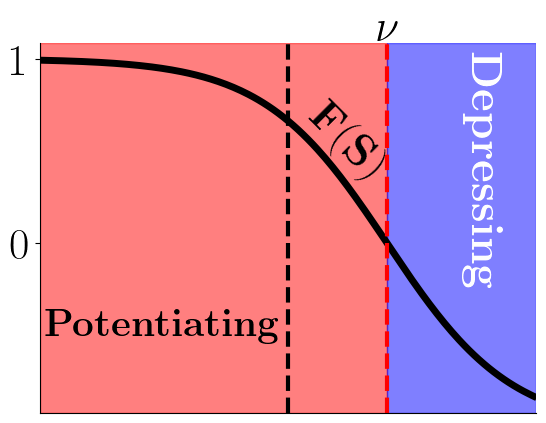

In [6]:
x = np.arange(0,2,0.01)
thr = 1.4
plt.plot(x,-np.tanh(2*(x-thr)),lw = 5,c='k')
plt.axvline(thr,lw=3,ls='--',c='r')
plt.axvline(1,lw=3,ls='--',c='k')
plt.text(thr,1.1,r'\bf{$\nu$}',ha='center',fontsize=32)
plt.axvspan(0, thr, alpha=0.5, color='red')
plt.axvspan(thr, 2, alpha=0.5, color='blue')
plt.text(0.02,-0.5,r'\bf Potentiating',fontsize=28)
plt.text(1.7,-0.2,r'\bf Depressing',fontsize=32,c='w',rotation=-90)
plt.text(1.05,0.35,r'$\mathbf{F(S)}$',fontsize=32,rotation=-45,c='k')
plt.xticks([])
plt.xlim([0,2])
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### g

([], [])

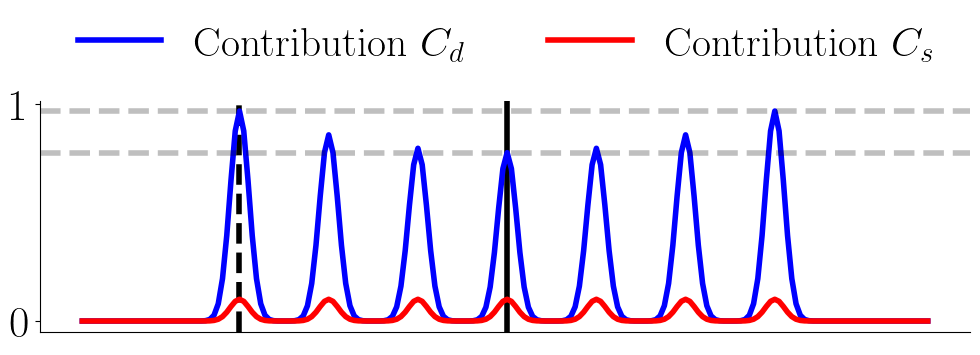

In [7]:
stims   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
lam = 1
Cs = 0.1
Cd = 2
xMax = 1

dx = 0.01
x = np.arange(-xMax,xMax,dx)
xplot = 6.66*x

C1  = np.zeros_like(x) 
C2  = np.zeros_like(x) 

Cd = initC(stims,Cd,lam)

for xs,c in zip(stims[0],Cd):
    C1 += (Cs)*np.exp(-1000*(x-xs)**2)
    C2 += (c)*np.exp(-1000*(x-xs)**2)
    
fig,ax = plt.subplots(figsize=(12,3))
plt.axvline(stims[0,0]*6.66,lw=4,c='k',ls='--')
plt.axvline(0,lw=4,c='k',ls='-')
plt.plot(xplot,C2,lw=4,c='b',label='Contribution $C_d$')
plt.plot(xplot,C1,lw=4,c='r',label='Contribution $C_s$')
#for s in stims[0]:
#    plt.axvline(s*6.66,c='k',lw=4,ls='--',alpha=0.25)
plt.axhline(C2.max(),c='k',lw=4,ls='--',alpha=0.25)
plt.axhline(C2[100],c='k',lw=4,ls='--',alpha=0.25)
leg =plt.legend(fontsize=30,loc=3,ncol=3,bbox_to_anchor=(0.,1))
leg.get_frame().set_linewidth(0.0)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_ylim()
plt.xticks([])

(0.32924943031407533, 0.5081309795088536)

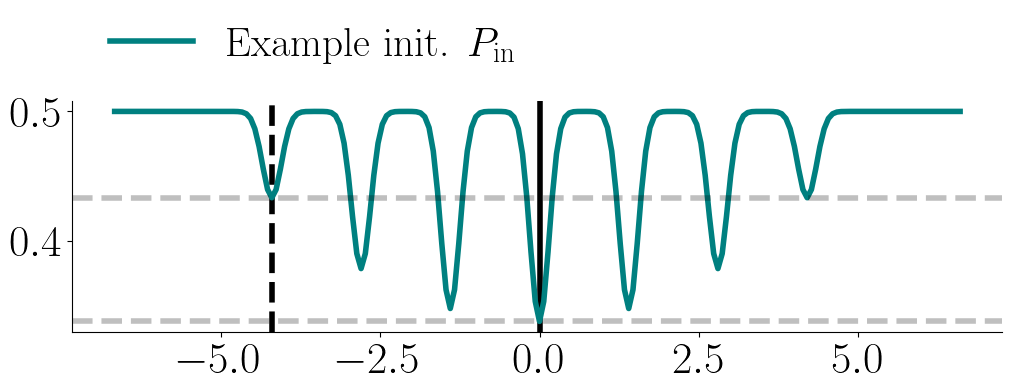

In [8]:
stims   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
lam = 1
Cs = 0.1
Cd = 2
xMax = 1

dx = 0.01
x = np.arange(-xMax,xMax,dx)
xplot = 6.66*x

C1  = np.zeros_like(x) 
C2  = np.zeros_like(x) 

C3 = np.ones_like(x)
Cd = initC(stims,Cd,lam)
Cd = 1-Cd

for xs,c in zip(stims[0],Cd):
    C1 += (Cs)*np.exp(-1000*(x-xs)**2)
    C2 += (Cs+c)*np.exp(-1000*(x-xs)**2)
    
fig,ax = plt.subplots(figsize=(12,3))
plt.axvline(stims[0,0]*6.66,lw=4,c='k',ls='--')
plt.axvline(0,lw=4,c='k',ls='-')
plt.plot(xplot,0.5*(1-C2),lw=4,c='teal',label='Example init. $P_\mathrm{in}$')

#plt.plot(xplot,C1,lw=4,c='r',label='Contribution $C_s$')
plt.axhline(0.5*(1-C2).min(),c='k',lw=4,ls='--',alpha=0.25)
plt.axhline(0.5*(1-C2)[37],c='k',lw=4,ls='--',alpha=0.25)
leg =plt.legend(fontsize=30,loc=3,ncol=3,bbox_to_anchor=(0.,1))
leg.get_frame().set_linewidth(0.0)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.get_ylim()

### h

100%|██████████████████████████████████| 16001/16001 [00:01<00:00, 10644.36it/s]


(array([0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 [Text(0, 0.75, '$\\mathdefault{0.75}$'),
  Text(0, 1.0, '$\\mathdefault{1.00}$'),
  Text(0, 1.25, '$\\mathdefault{1.25}$'),
  Text(0, 1.5, '$\\mathdefault{1.50}$'),
  Text(0, 1.75, '$\\mathdefault{1.75}$'),
  Text(0, 2.0, '$\\mathdefault{2.00}$')])

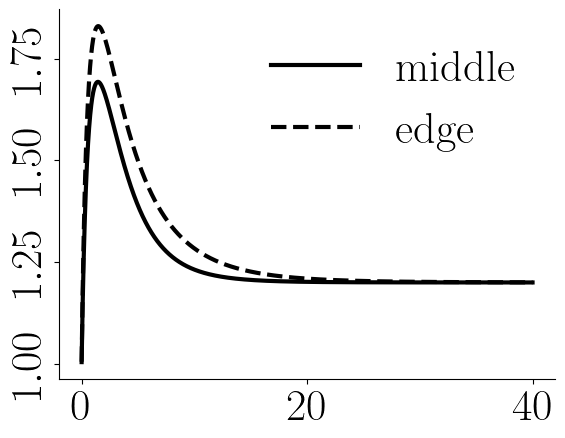

In [9]:
cPar  = [0.001,1]
p0Par = [0.01,8]
pPar  = [0.01,0.01,8]
zeta  = 1
phi   = 1
nu    = 1.2
stims   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
Cs = 0.1
S = RunSimul2(cPar,p0Par,pPar,zeta,phi,nu,stims)

fig,ax = plt.subplots()
plt.plot(np.linspace(0,40,16001),S[:,200],lw=3,c='k',label='middle')
plt.plot(np.linspace(0,40,16001),S[:,137],lw=3,c='k',ls='--',label='edge')
plt.legend(fontsize=32,frameon=False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.yticks(rotation=90,ha='right',va='center')

## Fig 2

In [10]:
SpineDir = DatDir+'3Spine/'
m,d1 = LoadThreeSpine(SpineDir,True)
mtot = np.hstack(m)
mtot3 = np.copy(mtot)
SpineDir = DatDir+'3SpineS/'
mS,d2 = LoadThreeSpine(SpineDir,False)

100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1791.19it/s]


[Errno 20] Not a directory: './DataProcessed/3Spine/.DS_Store/Spine/Synapse_l.json'


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 1897.56it/s]

[Errno 20] Not a directory: './DataProcessed/3SpineS/.DS_Store/Spine/Synapse_l.json'


In [11]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_three = np.array([[-0.13,0,0.13],[0,0,0]])

SpineWidth = 1000
SM3 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM3.Simulate()
xvec = SM3.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]

Min3_m = SM3.S_tot[:,stimlocs_three[1]]
Min3_e = SM3.S_tot[:,stimlocs_three[0]]

stims_three = np.array([[-0.25,0,0.25],[0,0,0]])

SpineWidth = 1000
SM3 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM3.Simulate()
xvec = SM3.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]

Max3_m = SM3.S_tot[:,stimlocs_three[1]]
Max3_e = SM3.S_tot[:,stimlocs_three[0]]

stims_three = np.array([[-0.19,0,0.19],[0,0,0]])

SpineWidth = 1000
SM3 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM3.Simulate()
xvec = SM3.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]

Mid3_m = SM3.S_tot[:,stimlocs_three[1]]
Mid3_e = SM3.S_tot[:,stimlocs_three[0]]




### d

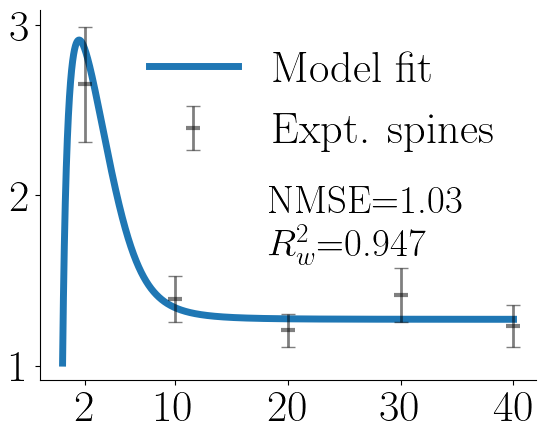

In [12]:
plt.plot(SM3.tvec,(SM3.S_tot[:,stimlocs_three[0]]
                   +SM3.S_tot[:,stimlocs_three[1]]+SM3.S_tot[:,stimlocs_three[2]])/3,lw=5,
         label='Model fit')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],mtot[3:].mean(axis=1),stats.sem(mtot[3:],axis=1),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Expt. spines',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.5,fontsize=32)
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40],[2,10,20,30,40])
plt.text(18.2,1.9,'NMSE='+str(NMSE(mtot[3:],(SM3.S_tot[:,stimlocs_three[0]]+SM3.S_tot[:,stimlocs_three[1]]+SM3.S_tot[:,stimlocs_three[2]])/3)),fontsize=28)
plt.text(18.2,1.65,r'$R_w^2$='+str(wR2(mtot[3:],(SM3.S_tot[:,stimlocs_three[0]]+SM3.S_tot[:,stimlocs_three[1]]+SM3.S_tot[:,stimlocs_three[2]])/3)),fontsize=28)

### e

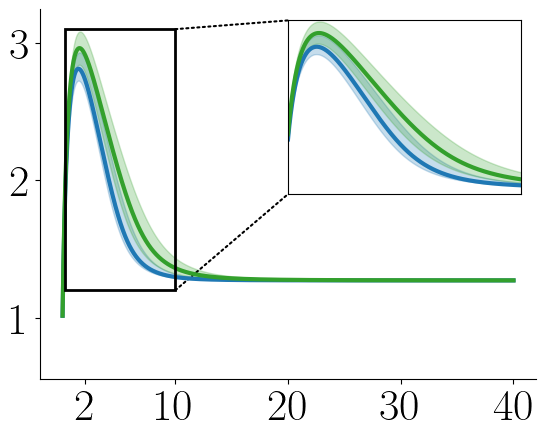

In [13]:
plt.fill_between(SM3.tvec,Max3_m,Min3_m,color=C[ColorDict['Control']],alpha=.25)
plt.plot(SM3.tvec,Mid3_m,color=C[ColorDict['Control']],lw=3)

plt.fill_between(SM3.tvec,Max3_e,Min3_e,color=C[ColorDict['CamKII']],alpha=.25)
plt.plot(SM3.tvec,Mid3_e,color=C[ColorDict['CamKII']],lw=3)

ax = plt.gca()

x1, x2, y1, y2 = 0.2, 10, 1.2, 3.1  # subregion of the original image
axins = ax.inset_axes(
    [0.5, 0.5, 0.47, 0.47],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
axins.fill_between(SM3.tvec, Max3_m, Min3_m, color=C[ColorDict['Control']], alpha=.25)
axins.plot(SM3.tvec, Mid3_m, color=C[ColorDict['Control']],lw=3)
axins.xaxis.set_ticks_position('none') 
axins.yaxis.set_ticks_position('none') 
axins.fill_between(SM3.tvec, Max3_e, Min3_e, color=C[ColorDict['CamKII']], alpha=.25)
axins.plot(SM3.tvec, Mid3_e, color=C[ColorDict['CamKII']],lw=3)
rect = (x1, y1, x2 - x1, y2 - y1)

box = ax.indicate_inset(rect, edgecolor="black", alpha=1,lw=2)

cp1 = ConnectionPatch(xyA=(x2, y1), xyB=(0, 0), axesA=ax, axesB=axins,
                      coordsA="data", coordsB="axes fraction", lw=1.5, ls=":")
cp2 = ConnectionPatch(xyA=(x2, y2), xyB=(0, 1), axesA=ax, axesB=axins,
                      coordsA="data", coordsB="axes fraction", lw=1.5, ls=":")

ax.add_patch(cp1)
ax.add_patch(cp2)
ax.set_ylim((0.5548009922104938, 3.2444933533858356))
ax.set_xticks([2,10,20,30,40],[2,10,20,30,40])
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### f

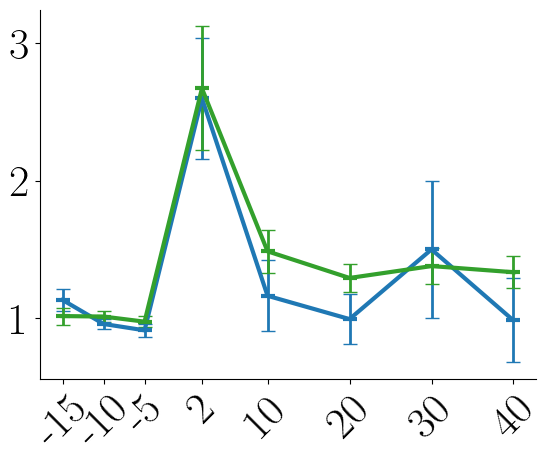

In [14]:
fig,ax = plt.subplots()
_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],m[0].mean(axis=1),stats.sem(m[0],axis=1),
             capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Control']],
             c=C[ColorDict['Control']],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
    
_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],m[1].mean(axis=1),stats.sem(m[1],axis=1),
             capsize=5,lw=3,marker='_',ecolor=C[ColorDict['CamKII']],
             c=C[ColorDict['CamKII']],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([-15,-10,-5,2,10,20,30,40],[-15,-10,-5,2,10,20,30,40],rotation=45)
plt.show()

### g

TtestResult(statistic=4.275299258358252, pvalue=0.0020641666312161975, df=9.0)
TtestResult(statistic=3.948393892030421, pvalue=0.0006839512946122988, df=22.0)


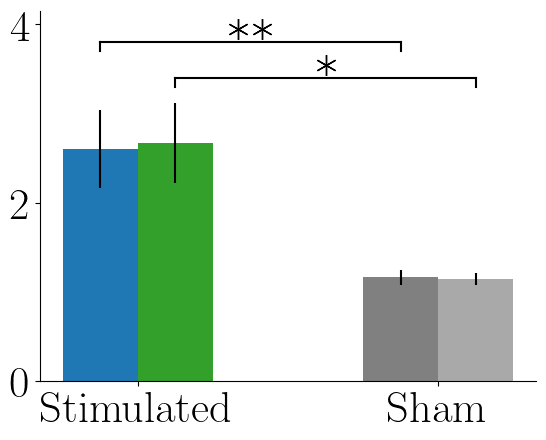

In [15]:
plt.bar([0],np.mean(m[0][3]),yerr=stats.sem(m[0][3]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.25],np.mean(m[1][3]),yerr=stats.sem(m[1][3]),width=0.25,color=C[ColorDict['CamKII']])

print(stats.ttest_ind(m[0][3],mS[0][3]))
PlotSig(0,1,3.8,0.15,0.1,stars=2,starpad=0.04)

print(stats.ttest_ind(m[1][3],mS[1][3]))
PlotSig(0.25,1.25,3.4,0.15,0.1)

plt.bar([1],np.mean(mS[0][3]),yerr=stats.sem(mS[0][3]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.25],np.mean(mS[1][3]),yerr=stats.sem(mS[1][3]),width=0.25,color=C[ColorDict['Sham']-1])
plt.xticks([0.125,1.125],['Stimulated','Sham'],fontsize=32)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### h

TtestResult(statistic=-1.027782110328748, pvalue=0.3308814299143187, df=9.0)
TtestResult(statistic=2.617491483054135, pvalue=0.015723611625395126, df=22.0)


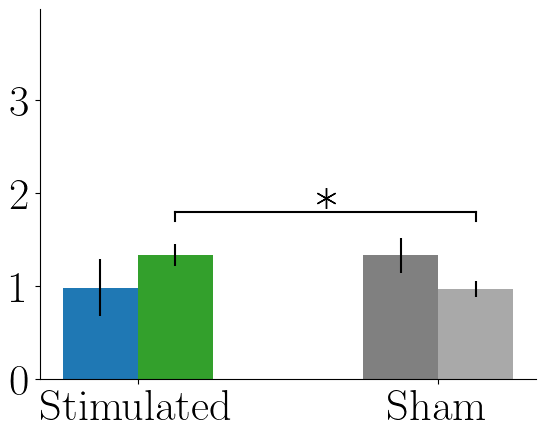

In [16]:
plt.bar([0],np.mean(m[0][-1]),yerr=stats.sem(m[0][-1]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.25],np.mean(m[1][-1]),yerr=stats.sem(m[1][-1]),width=0.25,color=C[ColorDict['CamKII']])

PlotSig(0.25,1.25,1.8,0.15,0.1)

print(stats.ttest_ind(m[0][-1],mS[0][-1]))
print(stats.ttest_ind(m[1][-1],mS[1][-1]))

plt.bar([1],np.mean(mS[0][-1]),yerr=stats.sem(mS[0][-1]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.25],np.mean(mS[1][-1]),yerr=stats.sem(mS[1][-1]),width=0.25,color=C[ColorDict['Sham']-1])
plt.xticks([0.125,1.125],['Stimulated','Sham'],fontsize=32)
plt.ylim((0.0, 3.9795))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)


## Fig 3

In [17]:
SpineDir = DatDir+'/1Spine/'
mt= LoadOneSpine(SpineDir,True)
SpineDir = DatDir+'/1SpineCalc/'
m= LoadOneSpine(SpineDir,True)
SpineDir = DatDir+'/1SpineCam/'
m2= LoadOneSpine(SpineDir,False)
SpineDir = DatDir+'/1SpineS/'
m3= LoadOneSpine(SpineDir,False)
mt1 = np.copy(mt)

100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 1403.78it/s]


In [18]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')


a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]*3
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]/2

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000
SM1 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_one)
SM1.Simulate()

In [19]:
C1 = SM1.zeta1*np.sum(SM1.C_tot[:,200])*SM1.dt
Pact1  = SM1.P_tot[:,200]*SM1.F(SM1.S_tot[:,200])
Pp1 = SM1.zeta2*np.sum(Pact1[Pact1>0])*SM1.dt
Pm1 = SM1.zeta2*np.sum(Pact1[Pact1<0])*SM1.dt

### d

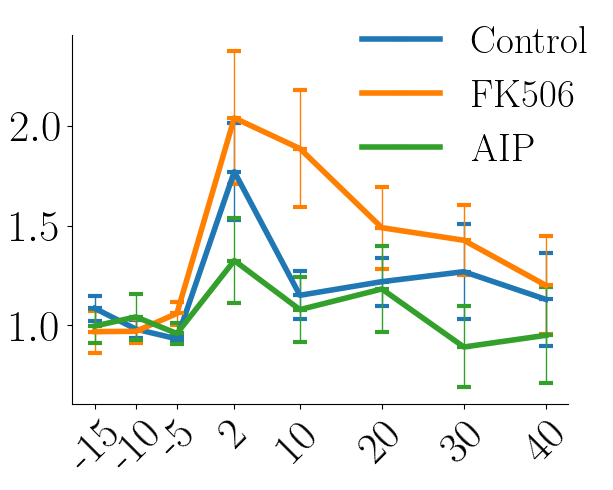

In [20]:
_,caps,_ = plt.errorbar(Fulltimes,np.nanmean(mt,axis=1),stats.sem(mt,axis=1,nan_policy='omit'),
             capsize=5,marker='_',ecolor=C[ColorDict['Control']],label='Control',
             c=C[ColorDict['Control']],elinewidth=1,ms=10,mew=3,capthick=1,lw=lw
            )   
_,caps,_ = plt.errorbar(Fulltimes,np.mean(m,axis=1),stats.sem(m,axis=1),
             capsize=5,marker='_',ecolor=C[ColorDict['Calcineurin']],
             c=C[ColorDict['Calcineurin']],elinewidth=1,ms=10,mew=3,capthick=1,lw=lw,label='FK506'
            )   
_,caps,_ = plt.errorbar(Fulltimes,np.mean(m2,axis=1),stats.sem(m2,axis=1),
             capsize=5,marker='_',ecolor=C[ColorDict['CamKII']],
             c=C[ColorDict['CamKII']],elinewidth=1,ms=10,mew=3,capthick=1,lw=lw,label='AIP'
            )   
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# get handles
handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
leg = ax.legend(handles, labels, framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1.11,1.12))
leg.get_frame().set_linewidth(0.0)
ax.set_xticks([-15,-10,-5,2,10,20,30,40],[-15,-10,-5,2,10,20,30,40],rotation=45)
plt.show()

### e

8.45750696434919e-05
0.00024233052272289513
0.5733071215748596
0.04432779004466877


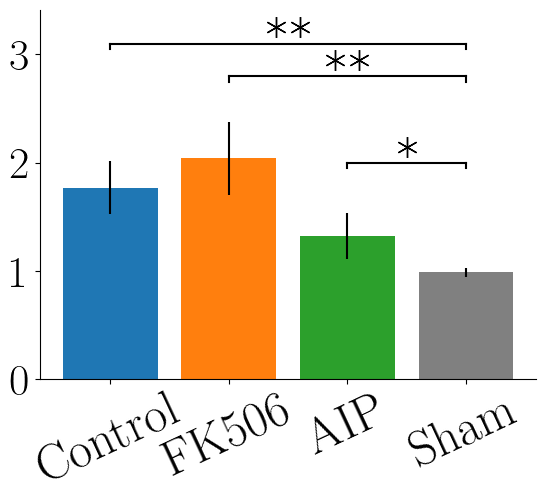

In [21]:
plt.bar([0],np.mean(mt[3]),yerr=stats.sem(mt[3]))
plt.bar([1],np.mean(m[3]),yerr=stats.sem(m[3]))
plt.bar([2],np.mean(m2[3]),yerr=stats.sem(m2[3]))
plt.bar([3],np.mean(m3[3]),yerr=stats.sem(m3[3]),color=C[ColorDict['Sham']])

PlotSig(2,3,2,0.15)
PlotSig(0,3,3.1,0.15,stars=2,starpad=0.1)
PlotSig(1,3,2.8,0.15,stars=2,starpad=0.1)
print(stats.ttest_ind(mt[3],m3[3]).pvalue) # -> Control vs Sham
print(stats.ttest_ind(m[3],m3[3]).pvalue) #  -> Cam vs Sham
print(stats.ttest_ind(mt[3],m[3]).pvalue) #  -> Control vs Cam
print(stats.ttest_ind(m2[3],m3[3]).pvalue) # -> Calc vs Sham
plt.xticks([0,1,2,3],['Control','FK506','AIP','Sham'],rotation=25,fontsize=36)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### f

0.04149493541405128
0.029274287460066564
0.8491606858742807
0.30199342908107735


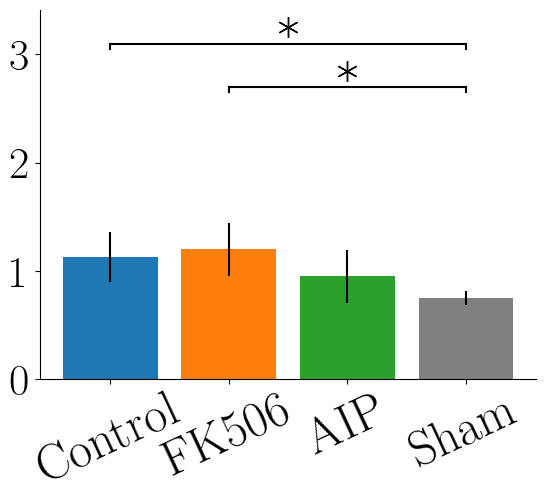

In [22]:
plt.bar([0],np.mean(mt[-1]),yerr=stats.sem(mt[-1]))
plt.bar([1],np.mean(m[-1]),yerr=stats.sem(m[-1]))
plt.bar([2],np.mean(m2[-1]),yerr=stats.sem(m2[-1]))
plt.bar([3],np.mean(m3[-1]),yerr=stats.sem(m3[-1]),color=C[ColorDict['Sham']])

PlotSig(0,3,3.1,0.15)
PlotSig(1,3,2.7,0.15)
print(stats.ttest_ind(mt[-1],m3[-1]).pvalue)
print(stats.ttest_ind(m[-1],m3[-1]).pvalue)
print(stats.ttest_ind(mt[-1],m[-1]).pvalue)
print(stats.ttest_ind(m2[-1],m3[-1]).pvalue)
plt.xticks([0,1,2,3],['Control','FK506','AIP','Sham'],rotation=25,fontsize=36)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### g

Text(20.2, 1.6, '$R_w^2$=0.744')

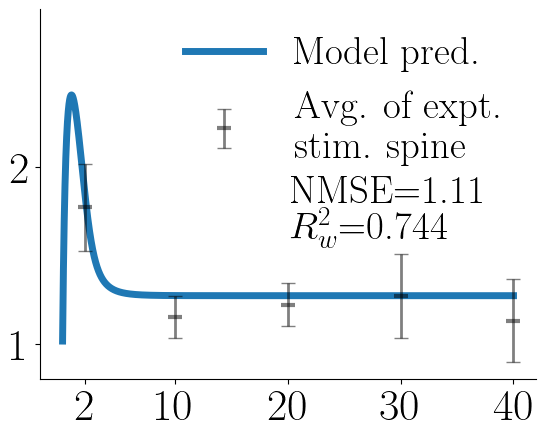

In [23]:
plt.plot(SM1.tvec,SM1.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Control']],lw=5,label=r'Model pred.')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],np.nanmean(mt[3:],axis=1),stats.sem(mt[3:],axis=1,nan_policy='omit'),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt.\n stim. spine',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1,1.02),frameon=False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
ax.set_ylim((0.8019776806368575, 2.8876038980241576))
plt.text(20.2,1.8,'NMSE='+str(NMSE(mt[3:], SM1.S_tot[:,stimlocs_three[1]])),fontsize=28)
plt.text(20.2,1.6,r'$R_w^2$='+str(wR2(mt[3:], SM1.S_tot[:,stimlocs_three[1]])),fontsize=28)

In [24]:
params = np.load(DatDir+'ModelFit/ControlFit1Calc.npy')


a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000

SMCalc = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],
                   [lam,mu,Cs,Cd],tMax,xMax,stims_one)
SMCalc.Simulate()


### h

Text(2, 0.9, '$R_w^2$=0.737')

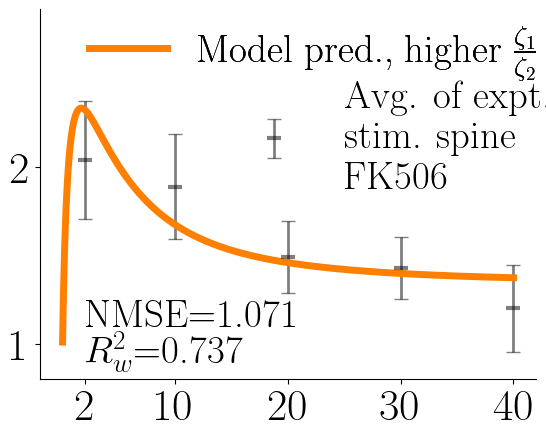

In [25]:

p1 ,caps,_ = plt.errorbar([2,10,20,30,40],np.nanmean(m[3:],axis=1),stats.sem(m[3:],axis=1,nan_policy='omit'),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt.\n stim. spine \n FK506',alpha=0.5
            )   
p2 = plt.plot(SMCalc.tvec,SMCalc.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Calcineurin']],lw=5,
         )
ax = plt.gca()
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.0,fontsize=28,loc=1,bbox_to_anchor = (1.1,0.9))
#l1 = ax.legend([p1], ['Avg. of expt.\n stim. spine \n FK506'], loc=1,framealpha=0.5,fontsize=24)
l2 = ax.legend([p2[0]], [r'Model pred., higher $\frac{\zeta_1}{\zeta_2}$'], loc=1,framealpha=0.0,fontsize=28,
                bbox_to_anchor=(1.075,1.05))
leg.get_frame().set_linewidth(0.0)
l2.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.add_artist(leg)
ax.add_artist(l2)
ax.spines["top"].set_visible(False)
ax.set_ylim((0.8019776806368575, 2.8876038980241576))
ax.set_xticks([2,10,20,30,40])
plt.text(2,1.1,'NMSE='+str(NMSE(m[3:], SMCalc.S_tot[:,stimlocs_three[1]])),fontsize=28)
plt.text(2,0.9,r'$R_w^2$='+str(wR2(m[3:], SMCalc.S_tot[:,stimlocs_three[1]])),fontsize=28)

In [26]:
params = np.load(DatDir+'ModelFit/ControlFit1Cam.npy')


a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]*1.05
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000

SMCam = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],
                   [lam,mu,Cs,Cd],tMax,xMax,stims_one)
SMCam.Simulate()


### i

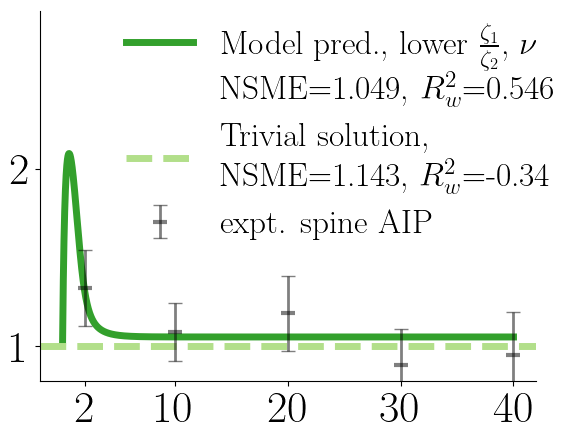

In [27]:
plt.plot(SMCam.tvec,SMCam.S_tot[:,stimlocs_three[1]],c=C[ColorDict['CamKII']],lw=5,
         label=r'\hspace{-14pt}Model pred., lower $\frac{\zeta_1}{\zeta_2}$, $\nu$ \\ NSME='+str(NMSE(m2[3:],SMCam.S_tot[:,stimlocs_three[1]]))+', $R_w^2$='+str(wR2(m2[3:],SMCam.S_tot[:,stimlocs_three[1]])))
plt.axhline(1,ls='--',c=C[ColorDict['CamKII']-1],lw=5,label='Trivial solution, \n NSME='+str(NMSE(m2[3:],np.ones(16001)))+', $R_w^2$='+str(wR2(m2[3:],np.ones(16001))))
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],np.nanmean(m2[3:],axis=1),stats.sem(m2[3:],axis=1,nan_policy='omit'),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='expt. spine AIP',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.0,fontsize=24,loc=1,bbox_to_anchor=(1.1,1.05))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim((0.8019776806368575, 2.8876038980241576))
ax.set_xticks([2,10,20,30,40])

## Fig 4 

In [28]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = 5*params[4]/7
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = 2.5*params[11]/7

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])
stims_seven   = np.array([[-0.36,-0.24,-0.12,0,0.12,0.24,0.36],[0,0,0,0,0,0,0]])

SpineWidth = 1000
stimlocs_seven = [np.argwhere(xvec == s)[0,0] for s in stims_seven[0]]


SM7 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_seven)
SM7.Simulate()

Min7_e = SM7.S_tot[:,stimlocs_seven[0]]
Min7_m = SM7.S_tot[:,stimlocs_seven[3]]

stims_seven   = np.array([[-0.78,-0.52,-0.26,0,0.26,0.52,0.78],[0,0,0,0,0,0,0]])

SpineWidth = 1000
stimlocs_seven = [np.argwhere(xvec == s)[0,0] for s in stims_seven[0]]


SM7 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_seven)
SM7.Simulate()

Max7_e = SM7.S_tot[:,stimlocs_seven[0]]
Max7_m = SM7.S_tot[:,stimlocs_seven[3]]

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])
stims_seven   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])

SpineWidth = 1000
stimlocs_seven = [np.argwhere(xvec == s)[0,0] for s in stims_seven[0]]


SM7 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_seven)
SM7.Simulate()

Mid7_e = SM7.S_tot[:,stimlocs_seven[0]]
Mid7_m = SM7.S_tot[:,stimlocs_seven[3]]

In [29]:
SpineDir = DatDir+'7Spine/'
m,d,p = LoadSevenSpine3(SpineDir)
SType = []
for testd in d:
    stype = []
    for td in testd:
        if((testd-td <= 0).all() or (testd-td>=0).all()):
           stype.append('o')
        else:
            diff = testd-td
            p1 = diff[diff>0].min()
            p2 = diff[diff<0].max()
            if(p1>2 or p2 < -2):
                stype.append('e')
            else:
                stype.append('m')
    SType.append(stype)
SType = np.hstack(SType)

S = SType[[not p1 for p1 in p]]

mt7 = np.copy(m)

mtot7 = np.copy(mtot)
SpineDirSham = DatDir+'7SpineS/'
mS,dS = LoadSevenSpine2(SpineDirSham,False)
mtotS = np.hstack(mS)

SpineDir = DatDir+'7SpineD/'
mD,dD = LoadSevenSpine2(SpineDir)
mtotD = np.hstack(mD)

100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 1905.76it/s]


[Errno 20] Not a directory: './DataProcessed/7Spine/.DS_Store/Spine/Synapse_l.json'
[Errno 20] Not a directory: './DataProcessed/7Spine/Index.txt/Spine/Synapse_l.json'
Expecting value: line 1101 column 1 (char 23773)


100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 1709.17it/s]


### d

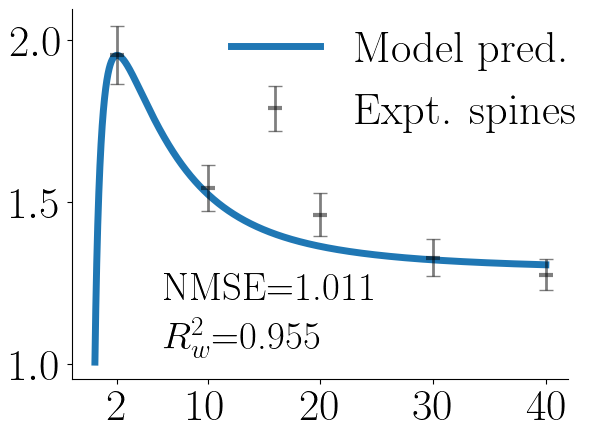

In [30]:
plt.plot(SM7.tvec,np.mean([SM7.S_tot[:,s] for s in stimlocs_seven],axis=0),lw=5
        ,label='Model pred.')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],m[:,3:].mean(axis=0),stats.sem(m[:,3:],axis=0),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Expt. spines',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
    
    ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
leg = ax.legend(framealpha=0.5,fontsize=32,loc=1,bbox_to_anchor=(1.1,1.05))
leg.get_frame().set_linewidth(0.0)
plt.text(6,1.2,'NMSE='+str(NMSE(m[:,3:].T,np.mean([SM7.S_tot[:,s] for s in stimlocs_seven],axis=0))),fontsize=28)
plt.text(6,1.05,r'$R^2_w$='+str(wR2(m[:,3:].T,np.mean([SM7.S_tot[:,s] for s in stimlocs_seven],axis=0))),fontsize=28)

### e

TtestResult(statistic=10.357058776728826, pvalue=2.034831998434742e-17, df=98.0)
TtestResult(statistic=2.7026905879972576, pvalue=0.008107891104322192, df=98.0)


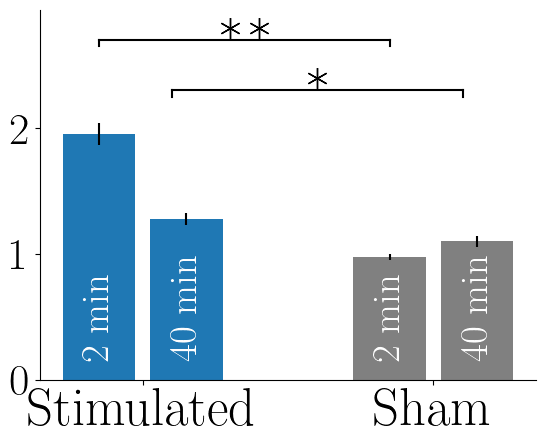

In [31]:
plt.bar([0],np.mean(m[:,3]),yerr=stats.sem(m[:,3]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.3],np.mean(m[:,-1]),yerr=stats.sem(m[:,-1]),width=0.25,color=C[ColorDict['Control']])

plt.bar([1],np.mean(mtotS[3]),yerr=stats.sem(mtotS[3]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.3],np.mean(mtotS[-1]),yerr=stats.sem(mtotS[-1]),width=0.25,color=C[ColorDict['Sham']])

PlotSig(0,1,2.7,0.1,stars=2,starpad=0.05)
print(stats.ttest_ind(m[:,3],mtotS[3]))

PlotSig(0.25,1.25,2.3,0.1)
print(stats.ttest_ind(m[:,-1],mtotS[-1]))

plt.text(-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(0.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')

plt.text(1-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(1.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')
plt.xticks([0.15,1.15],['Stimulated','Sham'],fontsize=38)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### f

Text(2, 1, '$R_w^2$=0.972')

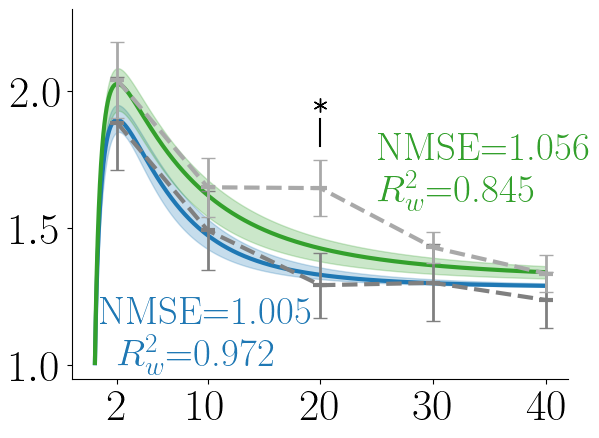

In [32]:
plt.fill_between(SM7.tvec,Min7_m,Max7_m,color=C[ColorDict['Control']],alpha=.25)
plt.plot(SM7.tvec,Mid7_m,color=C[ColorDict['Control']],lw=3)

plt.fill_between(SM7.tvec,Min7_e,Max7_e,color=C[ColorDict['CamKII']],alpha=.25)
plt.plot(SM7.tvec,Mid7_e,color=C[ColorDict['CamKII']],lw=3)
ax = plt.gca()
m1 = m[S=='m']
_,caps,_ = ax.errorbar([2,10,20,30,40],m1[:,3:].mean(axis=0),stats.sem(m1[:,3:],axis=0),
             capsize=5,lw=3,ls='--',marker='_',ecolor=C[ColorDict['Sham']],
             c=C[ColorDict['Sham']],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)

m2 = m[S=='e']
_,caps,_ = ax.errorbar([2,10,20,30,40],m2[:,3:].mean(axis=0),stats.sem(m2[:,3:],axis=0),
             capsize=5,lw=3,ls='--',marker='_',ecolor=C[ColorDict['Sham']-1],
             c=C[ColorDict['Sham']-1],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])

plt.plot([20,20],[1.8,1.9],c='k')
plt.plot(20,1.95,marker=(6, 2, 0),c='k',ms=10)

ax.set_ylim(0.9483729305222584,2.3)
plt.text(25,1.75,'NMSE='+str(NMSE(m2[:,3:].T,Mid7_e)),fontsize=28,c=C[ColorDict['CamKII']])
plt.text(25,1.6,'$R_w^2$='+str(wR2(m2[:,3:].T,Mid7_e)),fontsize=28,c=C[ColorDict['CamKII']])
plt.text(0.4,1.15,'NMSE='+str(NMSE(m1[:,3:].T,Mid7_m)),fontsize=28,c=C[ColorDict['Control']])
plt.text(2,1,'$R_w^2$='+str(wR2(m1[:,3:].T,Mid7_m)),fontsize=28,c=C[ColorDict['Control']])

### g

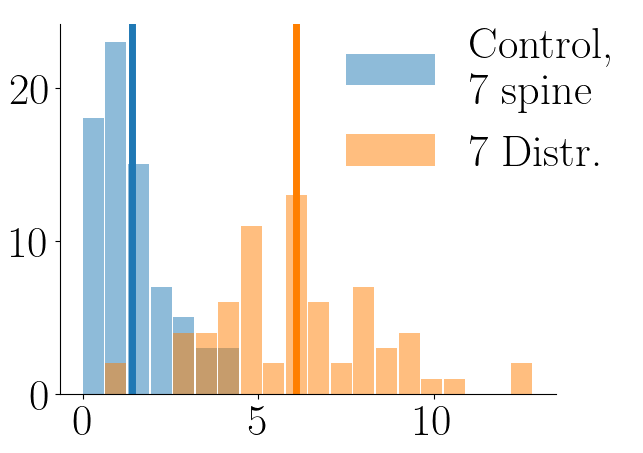

In [33]:
mind = []
for d2 in d:
    dt = np.sort(d2)
    for i in range(len(dt)):
        mind.append(min(abs(dt[i]-dt[(i-1)%len(dt)]),abs(dt[(i+1)%len(dt)]-dt[i])))
mindD = []
for d2 in dD:
    dt = np.sort(d2)
    for i in range(len(dt)):
        mindD.append(min(abs(dt[i]-dt[(i-1)%len(dt)]),abs(dt[(i+1)%len(dt)]-dt[i])))
        
plt.hist(mind,alpha=0.5,width=0.6,range=(0,max(mindD)),bins=20,color=C[ColorDict['Control']],label='Control, \n 7 spine')
plt.hist(mindD,alpha=0.5,width=0.6,range=(0,max(mindD)),bins=20,color=C[ColorDict['Calcineurin']],label='7 Distr.')

plt.axvline(np.mean(mind),color=C[ColorDict['Control']],lw=5)
plt.axvline(np.mean(mindD),color=C[ColorDict['Calcineurin']],lw=5)
ax = plt.gca()
leg = ax.legend(framealpha=0.5,fontsize=32,loc=1,bbox_to_anchor=[1.2,1.1],frameon=False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

In [34]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')
a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]*3
gamma = params[5]

nu = params[6]/1.1
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]/2

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])

SpineWidth = 1000
SM1d = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_one)
SM1d.Simulate()

params = np.load(DatDir+'ModelFit/ControlDistr.npy')

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]/1.1
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_seven   = np.array([[-1.89,-1.26,-0.63,0,0.63,1.26,1.89],[0,0,0,0,0,0,0]])

SpineWidth = 1000
SM2 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_one)
SM2.Simulate()



### h

Text(40, 1.65, 'p=0.004')

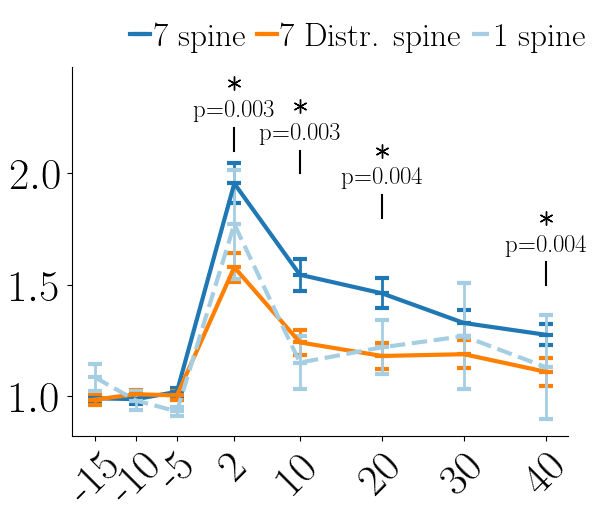

In [35]:
fig,ax = plt.subplots()

_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],m.mean(axis=0),stats.sem(m,axis=0),
         capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Control']],
         c=C[ColorDict['Control']],elinewidth=2,ms=10,mew=3,capthick=1,label='7 spine'
        )   

_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],mtotD.mean(axis=1),stats.sem(mtotD,axis=1),
         capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Calcineurin']],
         c=C[ColorDict['Calcineurin']],elinewidth=2,ms=10,mew=3,capthick=1,
                       label='7 Distr. spine'
        )   



_,caps,_ = ax.errorbar([-15,-10,-5,2,10,20,30,40],mt1.mean(axis=1),stats.sem(mt,axis=1),
         capsize=5,lw=3,marker='_',ecolor=C[ColorDict['Control']-1],
         c=C[ColorDict['Control']-1],elinewidth=2,ms=10,mew=3,capthick=1,
                       label='1 spine',ls='--'
        )   


handles, labels = ax.get_legend_handles_labels()
# remove the errorbars
handles = [h[0] for h in handles]
# use them in the legend
leg = ax.legend(handles, 
                labels,ncols=3, framealpha=0.5,fontsize=24,loc=1,
                bbox_to_anchor=(1.1,1.2),frameon=False,columnspacing=0.3,handlelength=0.6,handletextpad=0.1)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([-15,-10,-5,2,10,20,30,40],[-15,-10,-5,2,10,20,30,40],rotation=45)

plt.plot([20,20],[1.8,1.9],c='k')
plt.plot(20,2.1,marker=(6, 2, 0),c='k',ms=10)
plt.text(20,1.95,'p=0.004',ha='center',fontsize=18)

plt.plot([2,2],[2.1,2.2],c='k')
plt.plot(2,2.4,marker=(6, 2, 0),c='k',ms=10)
plt.text(2,2.25,'p=0.003',ha='center',fontsize=18)

plt.plot([10,10],[2,2.1],c='k')
plt.plot(10,2.3,marker=(6, 2, 0),c='k',ms=10)
plt.text(10,2.15,'p=0.003',ha='center',fontsize=18)

plt.plot([40,40],[1.5,1.6],c='k')
plt.plot(40,1.8,marker=(6, 2, 0),c='k',ms=10)
plt.text(40,1.65,'p=0.004',ha='center',fontsize=18)

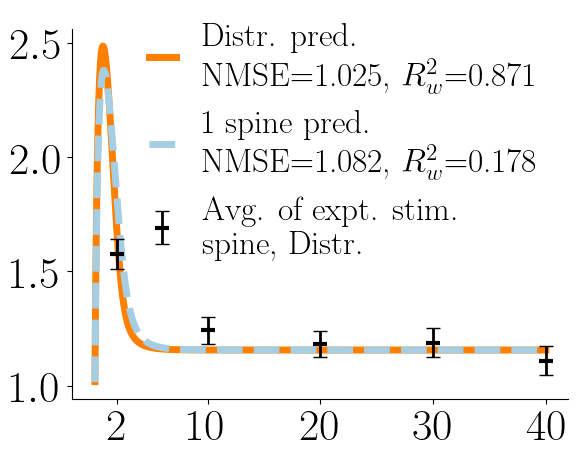

In [36]:
plt.plot(SM2.tvec,SM2.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Calcineurin']],lw=5,label='Distr. pred. \n NMSE='+
         str(NMSE(mtotD[3:],SM2.S_tot[:,stimlocs_three[1]]))+', $R_w^2$='+str(wR2(mtotD[3:],SM2.S_tot[:,stimlocs_three[1]])))
plt.plot(SM2.tvec,SM1d.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Control']-1],lw=5,label='1 spine pred. \n NMSE='+
         str(NMSE(mtotD[3:],SM1d.S_tot[:,stimlocs_three[1]]))+', $R_w^2$='+str(wR2(mtotD[3:],SM1.S_tot[:,stimlocs_three[1]])),ls='--')

ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],mtotD[3:].mean(axis=1),stats.sem(mtotD[3:],axis=1),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Avg. of expt. stim.\n spine, Distr.'
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
leg = ax.legend(framealpha=0.5,fontsize=24,loc=1,bbox_to_anchor=(1.,1.1),frameon=False,handlelength=0.8)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])

## Fig 5

In [37]:
SpineDir = DatDir+'15Spine/'
m,d = Load15Spine(SpineDir,True)
mtot = np.hstack(m)
mtot15 = np.copy(mtot)
SpineDir = DatDir+'15SpineS/'
ms,ds = Load15Spine(SpineDir,False)
mtots = np.hstack(m)

100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 1428.30it/s]


[Errno 20] Not a directory: './DataProcessed/15Spine/.DS_Store/Spine/Synapse_l.json'


100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 1980.21it/s]

[Errno 20] Not a directory: './DataProcessed/15SpineS/.DS_Store/Spine/Synapse_l.json'
[Errno 20] Not a directory: './DataProcessed/15SpineS/Index.txt/Spine/Synapse_l.json'
[Errno 2] No such file or directory: './DataProcessed/15SpineS/cell_6/Spine/Synapse_l.json'
[Errno 2] No such file or directory: './DataProcessed/15SpineS/cell_2/Spine/Synapse_l.json'
[Errno 2] No such file or directory: './DataProcessed/15SpineS/cell_4/Spine/Synapse_l.json'


In [38]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')
a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]/4
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]/15

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])
stims_seven   = np.array([[-0.63,-0.42,-0.21,0,0.21,0.42,0.63],[0,0,0,0,0,0,0]])
stims_fifteen = np.array([[-1.68,-1.44,-1.2,-0.96,-0.72,-0.48,-0.24,0,0.24,0.48,0.72,0.96,1.2,1.44,1.68],
                        [0]*15])
    
SpineWidth = 1000
stimlocs_seven = [np.argwhere(xvec == s)[0,0] for s in stims_seven[0]]
stimlocs_15 = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]


SM15 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_fifteen)
SM15.Simulate()

In [39]:
SpineDir = DatDir+'15Spine/'
m,d,p = LoadSevenSpine3(SpineDir)
SType = []
for testd in d:
    stype = []
    for td in testd:
        if((testd-td <= 0).all() or (testd-td>=0).all()):
           stype.append('o')
        else:
            diff = testd-td
            p1 = diff[diff>0].min()
            p2 = diff[diff<0].max()
            if(p1>3 or p2 < -3):
                stype.append('e')
            else:
                stype.append('m')
    SType.append(stype)
SType = np.hstack(SType)

S = SType[[not p1 for p1 in p]]

mt15 = np.copy(m)

params = np.load(DatDir+'ModelFit/ControlFit3.npy')
a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]/4
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]/15

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_one   = np.array([[0],[0]])
dist = 0.17
side = [np.round(dist*i,2) for i in range(1,8)]
stims = np.round(-1*np.array(side[::-1]),2).tolist()+[0]+side
stims_fifteen = np.array([stims,
                        [0]*15])
    
SpineWidth = 1000
stimlocs_fifteen = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]
stimlocs_15 = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]


SM15 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_fifteen)
SM15.Simulate()

Min15_e = SM15.S_tot[:,stimlocs_fifteen[0]]
Min15_m = SM15.S_tot[:,stimlocs_fifteen[7]]

dist = 0.26
side = [np.round(dist*i,2) for i in range(1,8)]
stims = np.round(-1*np.array(side[::-1]),2).tolist()+[0]+side
stims_fifteen = np.array([stims,
                        [0]*15])
    
SpineWidth = 1000
stimlocs_fifteen = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]
stimlocs_15 = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]


SM15 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_fifteen)
SM15.Simulate()

Max15_e = SM15.S_tot[:,stimlocs_fifteen[0]]
Max15_m = SM15.S_tot[:,stimlocs_fifteen[7]]

stims_one   = np.array([[0],[0]])
stims_fifteen = np.array([[-1.68,-1.44,-1.2,-0.96,-0.72,-0.48,-0.24,0,0.24,0.48,0.72,0.96,1.2,1.44,1.68],
                        [0]*15])
    
SpineWidth = 1000
stimlocs_fifteen = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]
stimlocs_15 = [np.argwhere(xvec == s)[0,0] for s in stims_fifteen[0]]


SM15 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_fifteen)
SM15.Simulate()

Mid15_e = SM15.S_tot[:,stimlocs_fifteen[0]]
Mid15_m = SM15.S_tot[:,stimlocs_fifteen[7]]

100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 2825.26it/s]


[Errno 20] Not a directory: './DataProcessed/15Spine/.DS_Store/Spine/Synapse_l.json'


### d

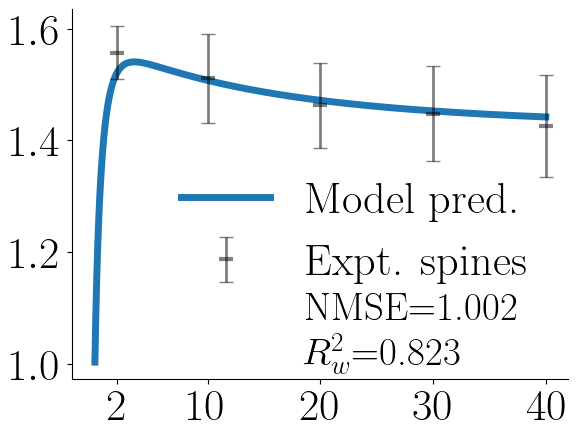

In [40]:
plt.plot(SM15.tvec,np.mean([SM15.S_tot[:,s] for s in stimlocs_15],axis=0),lw=5
        ,label='Model pred.')
ax = plt.gca()
_,caps,_ = ax.errorbar([2,10,20,30,40],mtot[3:].mean(axis=1),stats.sem(mtot[3:],axis=1),
             capsize=5,ls='none',marker='_',ecolor='k',
             c='k',elinewidth=2,ms=10,mew=3,capthick=1,label='Expt. spines',alpha=0.5
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
    
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
leg = ax.legend(framealpha=0.5,fontsize=32,loc=4,bbox_to_anchor=(1,0.15),frameon=False)
plt.text(18.6,1.08,'NMSE='+str(NMSE(mtot[3:], np.mean([SM15.S_tot[:,s] for s in stimlocs_15],axis=0))),fontsize=28)
plt.text(18.5,1,'$R_w^2$='+str(wR2(mtot[3:], np.mean([SM15.S_tot[:,s] for s in stimlocs_15],axis=0))),fontsize=28)

### e

TtestResult(statistic=9.898886442732541, pvalue=5.104417252897492e-18, df=147.0)
TtestResult(statistic=3.4533747277224123, pvalue=0.0007234449238084287, df=147.0)


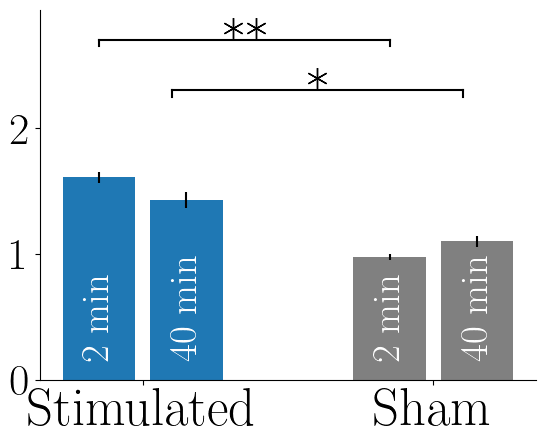

In [41]:
plt.bar([0],np.mean(m[:,3]),yerr=stats.sem(m[:,3]),width=0.25,color=C[ColorDict['Control']])
plt.bar([0.3],np.mean(m[:,-1]),yerr=stats.sem(m[:,-1]),width=0.25,color=C[ColorDict['Control']])

plt.bar([1],np.mean(mtotS[3]),yerr=stats.sem(mtotS[3]),width=0.25,color=C[ColorDict['Sham']])
plt.bar([1.3],np.mean(mtotS[-1]),yerr=stats.sem(mtotS[-1]),width=0.25,color=C[ColorDict['Sham']])

PlotSig(0,1,2.7,0.1,stars=2,starpad=0.04)
print(stats.ttest_ind(m[:,3],mtotS[3]))

PlotSig(0.25,1.25,2.3,0.1)
print(stats.ttest_ind(m[:,-1],mtotS[-1]))

plt.text(-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(0.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')

plt.text(1-0.06,0.2,'2 min',rotation=90,fontsize=28,color='w')
plt.text(1.3-0.06,0.2,'40 min',rotation=90,fontsize=28,color='w')
plt.xticks([0.15,1.15],['Stimulated','Sham'],fontsize=38)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### f

0.03844834973471283
0.004989326719938449


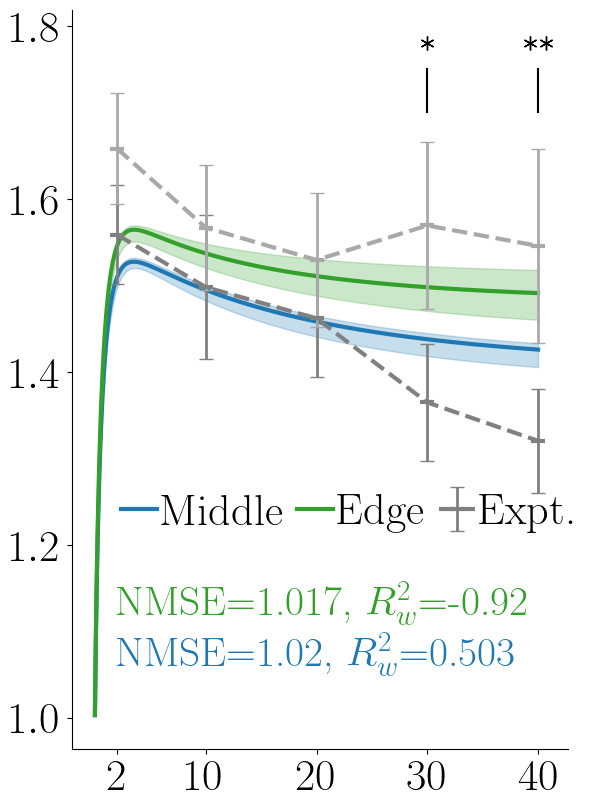

In [42]:
fig,ax = plt.subplots(figsize=(6.4,9.6))
plt.fill_between(SM15.tvec,Min15_m,Max15_m,color=C[ColorDict['Control']],alpha=.25)
plt.plot(SM15.tvec,Mid15_m,color=C[ColorDict['Control']],label='Middle',lw=3)

plt.fill_between(SM15.tvec,Min15_e,Max15_e,color=C[ColorDict['CamKII']],alpha=.25)
plt.plot(SM15.tvec,Mid15_e,color=C[ColorDict['CamKII']],label='Edge',lw=3)

ax = plt.gca()
m1 = m[S=='m']
_,caps,_ = ax.errorbar([2,10,20,30,40],m1[:,3:].mean(axis=0),stats.sem(m1[:,3:],axis=0),
             capsize=5,lw=3,ls='--',marker='_',ecolor=C[ColorDict['Sham']],
             c=C[ColorDict['Sham']],elinewidth=2,ms=10,mew=3,capthick=1,label='Expt.'
            )   
for cap in caps:
    cap.set_markeredgewidth(1)

m2 = m[np.array(S=='e')+np.array(S=='o')]
_,caps,_ = ax.errorbar([2,10,20,30,40],m2[:,3:].mean(axis=0),stats.sem(m2[:,3:],axis=0),
             capsize=5,lw=3,ls='--',marker='_',ecolor=C[ColorDict['Sham']-1],
             c=C[ColorDict['Sham']-1],elinewidth=2,ms=10,mew=3,capthick=1
            )   
for cap in caps:
    cap.set_markeredgewidth(1)
plt.text(2,1.12,'NMSE='+str(NMSE(m2[:,3:].T,Mid15_e))+', $R_w^2$='+str(wR2(m2[:,3:].T,Mid15_e)),fontsize=30,color=C[ColorDict['CamKII']])
plt.text(2,1.06,'NMSE='+str(NMSE(m1[:,3:].T,Mid15_m))+', $R_w^2$='+str(wR2(m1[:,3:].T,Mid15_m)),fontsize=30,color=C[ColorDict['Control']])

leg = ax.legend(framealpha=0.5,fontsize=32,frameon=False,ncol=3
                ,columnspacing=0.3,handlelength=0.8,handletextpad=0.1,loc=1,
                bbox_to_anchor=(1.1,0.4))
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])

plt.plot([30,30],[1.7,1.75],c='k')
plt.plot(30,1.78,marker=(6, 2, 0),c='k',ms=10)

plt.plot([40,40],[1.7,1.75],c='k')
plt.plot(39.3,1.78,marker=(6, 2, 0),c='k',ms=10)
plt.plot(40.7,1.78,marker=(6, 2, 0),c='k',ms=10)

print(stats.ttest_ind(m1[-2],m2[-2]).pvalue)
print(stats.ttest_ind(m1[-1],m2[-1]).pvalue)

### g

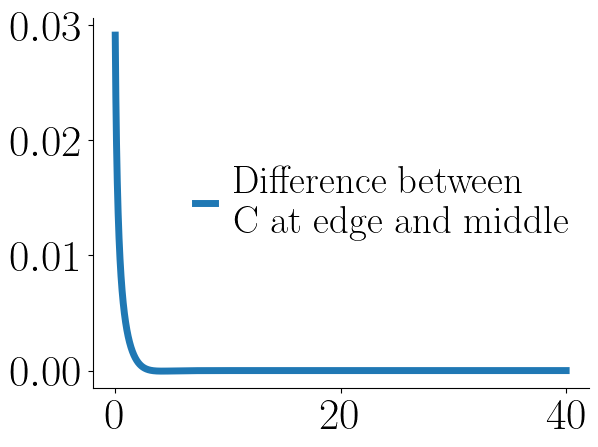

In [43]:
plt.plot(SM15.tvec,SM15.C_tot[:,stimlocs_fifteen[0]]-SM15.C_tot[:,stimlocs_fifteen[7]],
         c=C[ColorDict['Control']],lw=5,label='Difference between \n C at edge and middle')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(ncols=2,fontsize=28,loc=5,frameon=False,handlelength=0.5,borderpad=0.0,
             handletextpad=0.5,columnspacing=0.5)
plt.savefig('/Users/maximilianeggl/Dropbox/PostDoc/Rebuttal2Figs/Review/Figures/15CDiff.pdf',
            format='pdf',bbox_inches='tight')

### h

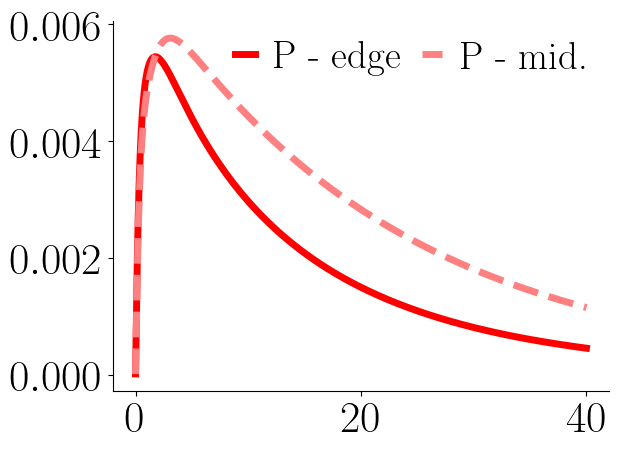

In [44]:

plt.plot(SM15.tvec,zeta1*SM15.P_tot[:,stimlocs_fifteen[0]],
         c= [1,0,0],lw=5,label='P - edge')
plt.plot(SM3.tvec,zeta1*SM15.P_tot[:,stimlocs_fifteen[7]],
         c= [1,0.5,0.5],lw=5,label='P - mid.',ls='--')
#plt.axhline(SM3.C_tot[0,stimlocs_three[0]],lw=3,ls='--',c=C[ColorDict['Sham']],label='Init. C - edge')
#plt.axhline(SM3.C_tot[0,stimlocs_three[1]],lw=3,c=C[ColorDict['Sham']-1],ls='--',label='Init. C - mid.')
plt.legend(ncols=2,fontsize=28,loc=1,frameon=False,handlelength=0.5,borderpad=0.0,
             handletextpad=0.5,columnspacing=0.5)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig('/Users/maximilianeggl/Dropbox/PostDoc/Rebuttal2Figs/Review/Figures/15P.pdf',
            format='pdf',bbox_inches='tight')

## Fig 6

### a

(0.9076591483301499, 3.006948551593322)

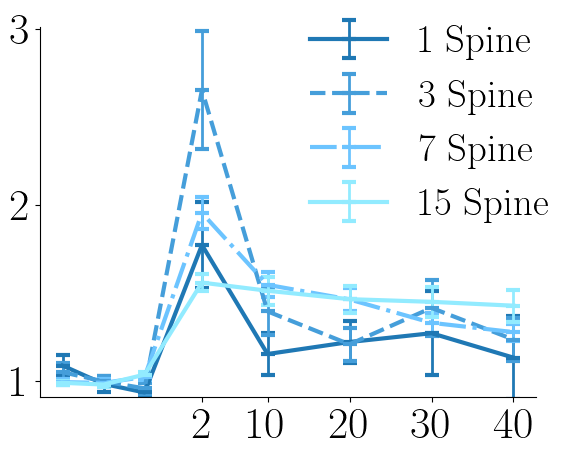

In [45]:
_,caps,_ = plt.errorbar([-15,-10,-5,2,10,20,30,40],np.nanmean(mt,axis=1),stats.sem(mt,axis=1,nan_policy='omit'),
             capsize=5,marker='_',ecolor=C[ColorDict['Control']],
             c=C[ColorDict['Control']],lw=3,elinewidth=2,ms=10,mew=3,capthick=1,label='1 Spine'
            )   

_,caps,_ = plt.errorbar([-15,-10,-5,2,10,20,30,40],np.nanmean(mtot3,axis=1),stats.sem(mtot3,axis=1,nan_policy='omit'),
             capsize=5,marker='_',ecolor=C[ColorDict['Control']]+0.15,
            c=C[ColorDict['Control']]+0.15,lw=3,elinewidth=2,ms=10,mew=3,capthick=1,label='3 Spine',ls='--'
            )   

_,caps,_ = plt.errorbar([-15,-10,-5,2,10,20,30,40],np.nanmean(mt7,axis=0),stats.sem(mt7,axis=0,nan_policy='omit'),
             capsize=5,marker='_',ecolor=np.clip(C[ColorDict['Control']]+0.3,0,1),
            c=np.clip(C[ColorDict['Control']]+0.3,0,1),lw=3,elinewidth=2,ms=10,mew=3,capthick=1,label='7 Spine',ls='-.'
            )   

_,caps,_ = plt.errorbar([-15,-10,-5,2,10,20,30,40],np.nanmean(mtot15,axis=1),stats.sem(mtot15,axis=1,nan_policy='omit'),
             capsize=5,marker='_',ecolor=np.clip(C[ColorDict['Control']]+0.45,0,1),
            c=np.clip(C[ColorDict['Control']]+0.45,0,1),lw=3,elinewidth=2,ms=10,mew=3,capthick=1,label='15 Spine'
            )   
plt.legend(fontsize=28,frameon=False,loc = 1,bbox_to_anchor=(1.1,1.1))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
plt.ylim((0.9076591483301499, 3.006948551593322))

### b

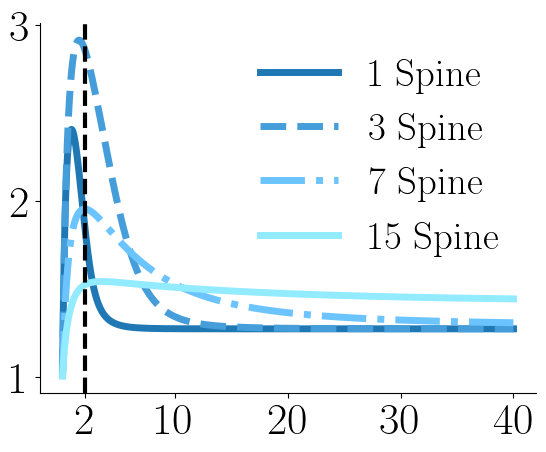

In [46]:
plt.plot(SM1.tvec,SM1.S_tot[:,stimlocs_three[1]],c=C[ColorDict['Control']],lw=5,label=r'1 Spine')
plt.plot(SM3.tvec,(SM3.S_tot[:,stimlocs_three[0]]
                   +SM3.S_tot[:,stimlocs_three[1]]+SM3.S_tot[:,stimlocs_three[2]])/3,lw=5,c=C[ColorDict['Control']]+0.15,
         label='3 Spine',ls='--')

plt.plot(SM7.tvec,np.mean([SM7.S_tot[:,s] for s in stimlocs_seven],axis=0),lw=5,c=np.clip(C[ColorDict['Control']]+0.3,0,1),
        label='7 Spine',ls='-.')
plt.plot(SM15.tvec,np.mean([SM15.S_tot[:,s] for s in stimlocs_15],axis=0),lw=5,c=np.clip(C[ColorDict['Control']]+0.45,0,1),
         label='15 Spine')
plt.legend(fontsize=28,frameon=False)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
plt.gca().get_ylim()
plt.gca().get_xlim()
plt.axvline(2,c='k',lw=3,ls='--')

### c

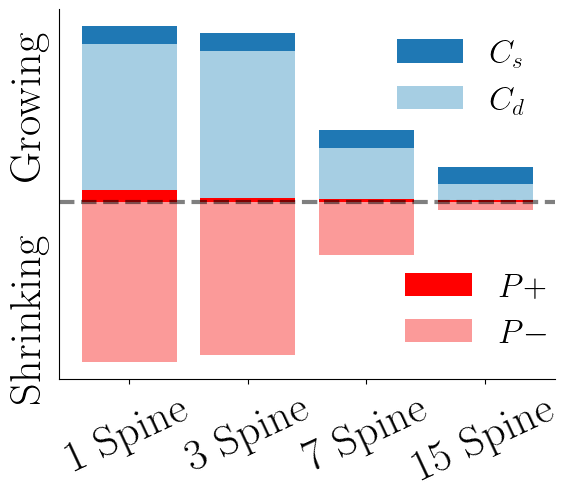

In [47]:
C1 = SM1.zeta1*np.sum(SM1.C_tot[:,200])*SM1.dt
Pact1  = SM1.P_tot[:,200]*SM1.F(SM1.S_tot[:,200])
Pp1 = SM1.zeta2*np.sum(Pact1[Pact1>0])*SM1.dt
Pm1 = SM1.zeta2*np.sum(Pact1[Pact1<0])*SM1.dt

C3 = SM3.zeta1*np.sum([SM3.C_tot[:,s] for s in stimlocs_three],axis=1).mean()*SM1.dt
Pact3  = np.mean([SM3.P_tot[:,s]*SM3.F(SM3.S_tot[:,s]) for s in stimlocs_three],axis=0)
Pp3 = SM3.zeta2*np.sum(Pact3[Pact3>0])*SM1.dt
Pm3 = SM3.zeta2*np.sum(Pact3[Pact3<0])*SM1.dt

C7 = SM7.zeta1*np.sum([SM7.C_tot[:,s] for s in stimlocs_seven],axis=1).mean()*SM1.dt
Pact7  = np.mean([SM7.P_tot[:,s]*SM7.F(SM7.S_tot[:,s]) for s in stimlocs_seven],axis=0)
Pp7 = SM7.zeta2*np.sum(Pact7[Pact7>0])*SM1.dt
Pm7 = SM7.zeta2*np.sum(Pact7[Pact7<0])*SM1.dt

C15 = SM15.zeta1*np.sum([SM15.C_tot[:,s] for s in stimlocs_15],axis=1).mean()*SM1.dt
Pact15  = np.mean([SM15.P_tot[:,s]*SM15.F(SM15.S_tot[:,s]) for s in stimlocs_15],axis=0)
Pp15 = SM15.zeta2*np.sum(Pact15[Pact15>0])*SM1.dt
Pm15 = SM15.zeta2*np.sum(Pact15[Pact15<0])*SM1.dt

p1 =plt.bar([1,2,3,4],[Pp1+C1,Pp3+C3,
                   Pp7+C7,Pp15+C15]
       ,label = r'$C_d$',color=C[ColorDict['Control']])
p2 =plt.bar([1,2,3,4],[Pp1+C1-SM3.C_s,Pp3+C3-SM3.C_s,
                   Pp7+C7-SM7.C_s,Pp15+C15-SM15.C_s]
       ,label = r'$C_d$',color=C[ColorDict['Control']-1])
p3 =plt.bar([1,2,3,4],[Pp1*100,Pp3*100,
                   Pp7*100,Pp15*100]
       ,label = r'I$C_d$',color='r')

p4 =plt.bar([1,2,3,4],[Pm1,Pm3,
                   Pm7,Pm15]
       ,label = r'Init. $C_d$',color=C[ColorDict['CHX']-1])
plt.axhline(0,ls='--',lw=3,c='k',alpha=0.5)
plt.yticks([-0.75,2.5],['Shrinking','Growing'],rotation=90)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,        # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) 
plt.xticks([1,2,3,4],['1 Spine', '3 Spine','7 Spine','15 Spine'],rotation=25)
ax = plt.gca()
l1 = plt.legend([p1,p2], [r"$C_s$",r'$C_d$'], loc=1,framealpha=0.5,fontsize=24)
l2 = plt.legend([p3,p4], [r'$P+$',r'$P-$'], loc=4,framealpha=0.5,fontsize=24,
                bbox_to_anchor=(1.05,0))
ax.add_artist(l1)
l1.get_frame().set_linewidth(0.0)
l2.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### d

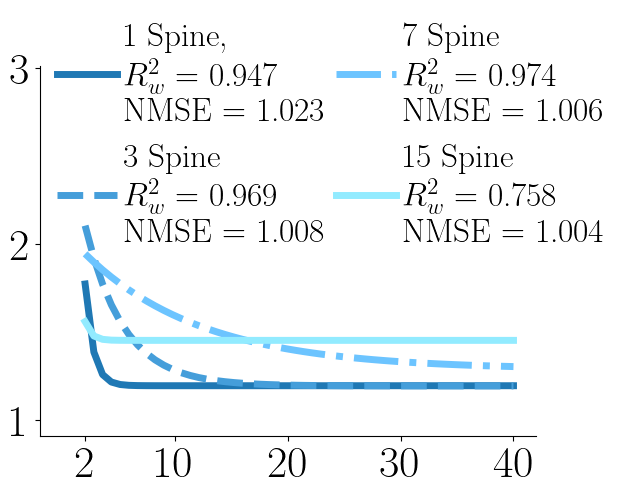

In [48]:
plt.plot(np.linspace(2,40),expfunc(np.linspace(2,40),10.        ,  1.42561426,  1.1927622 ),c=C[ColorDict['Control']],lw=5,
         label='1 Spine, \n $R_w^2$ = 0.947 \n NMSE = 1.023')
plt.plot(np.linspace(2,40),expfunc(np.linspace(2,40),1.63508689, 0.29275822, 1.19162033),lw=5,c=C[ColorDict['Control']]+0.15,
         label='3 Spine \n $R_w^2$ = 0.969\n NMSE = 1.008',ls='--')

plt.plot(np.linspace(2,40),expfunc(np.linspace(2,40),0.79685231, 0.09613511, 1.28446187),lw=5,c=np.clip(C[ColorDict['Control']]+0.3,0,1),
        label='7 Spine\n $R_w^2$ = 0.974\n NMSE = 1.006',ls='-.')
plt.plot(np.linspace(2,40),expfunc(np.linspace(2,40),4.51101028, 1.87255803, 1.4503617),lw=5,c=np.clip(C[ColorDict['Control']]+0.45,0,1),
         label='15 Spine\n $R_w^2$ = 0.758\n NMSE = 1.004')
plt.legend(fontsize=24,loc=1,frameon=False,ncols=2,columnspacing=0.3,handlelength=1.8,handletextpad=0.2,bbox_to_anchor=(1.2,1.2))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([2,10,20,30,40])
plt.ylim((0.9076591483301499, 3.006948551593322))
plt.xlim((-2.0, 42.0))

### e

100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 3611.63it/s]
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_67635/2791777089.py:128: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)+c
/Users/maximilianeggl/miniconda3/envs/ToolFigs/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 2339.10it/s]
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_67635/2791777089.py:128: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)+c


[Errno 20] Not a directory: './DataProcessed/3Spine/.DS_Store/Spine/Synapse_l.json'


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 2012.97it/s]


[Errno 20] Not a directory: './DataProcessed/7Spine/.DS_Store/Spine/Synapse_l.json'
[Errno 20] Not a directory: './DataProcessed/7Spine/Index.txt/Spine/Synapse_l.json'
Expecting value: line 1101 column 1 (char 23773)


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 2062.17it/s]


[Errno 20] Not a directory: './DataProcessed/15Spine/.DS_Store/Spine/Synapse_l.json'


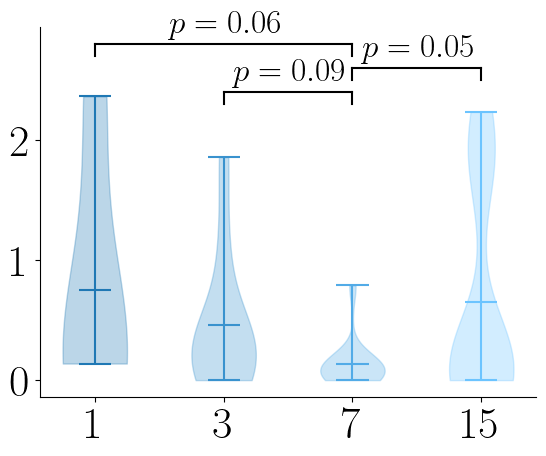

In [49]:
SpineDir = DatDir+'/1Spine/'
mt= LoadOneSpine(SpineDir,False)
mt1 = np.copy(mt)
d1 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mt[3:,i],maxfev=5000)[0][1] for i in range(mt.shape[1])])

SpineDir = DatDir+'3Spine/'
m,_ = LoadThreeSpine(SpineDir,True)
mtot = np.hstack(m)
mtot3 = np.copy(mtot)
d3 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mtot3[3:,i],maxfev=5000)[0][1] for i in range(mtot3.shape[1])])

SpineDir = DatDir+'7Spine/'
m,_ = LoadSevenSpine(SpineDir,True)
mtot = np.hstack(m)
mtot7 = np.copy(mtot)
d7 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mtot7[3:,i],maxfev=5000)[0][1] for i in range(mtot7.shape[1])])

SpineDir = DatDir+'15Spine/'
m,_ = Load15Spine(SpineDir,True)
mtot = np.hstack(m)
mtot15 = np.copy(mtot)
d15 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mtot15[3:,i],maxfev=5000)[0][1] for i in range(mtot15.shape[1])])

vp = plt.violinplot(np.array(d1)[d1<10],showmeans=True)
for pc in vp['bodies']:
    pc.set_facecolor(C[ColorDict['Control']])
    pc.set_edgecolor(C[ColorDict['Control']])
vp['cmaxes'].set_color(C[ColorDict['Control']])
vp['cmins'].set_color(C[ColorDict['Control']])
vp['cbars'].set_color(C[ColorDict['Control']])
vp['cmeans'].set_color(C[ColorDict['Control']])
vp = plt.violinplot(np.array(d3)[d3<10],positions=[2],showmeans=True)
for pc in vp['bodies']:
    pc.set_facecolor(np.clip(C[ColorDict['Control']]+0.1,0,1))
    pc.set_edgecolor(np.clip(C[ColorDict['Control']]+0.1,0,1))
vp['cmaxes'].set_color(np.clip(C[ColorDict['Control']]+0.1,0,1))
vp['cmins'].set_color(np.clip(C[ColorDict['Control']]+0.1,0,1))
vp['cbars'].set_color(np.clip(C[ColorDict['Control']]+0.1,0,1))
vp['cmeans'].set_color(np.clip(C[ColorDict['Control']]+0.1,0,1))
vp = plt.violinplot(np.array(d7)[d7<10],positions=[3],showmeans=True)
for pc in vp['bodies']:
    pc.set_facecolor(np.clip(C[ColorDict['Control']]+0.2,0,1))
    pc.set_edgecolor(np.clip(C[ColorDict['Control']]+0.2,0,1))
vp['cmaxes'].set_color(np.clip(C[ColorDict['Control']]+0.2,0,1))
vp['cmins'].set_color(np.clip(C[ColorDict['Control']]+0.2,0,1))
vp['cbars'].set_color(np.clip(C[ColorDict['Control']]+0.2,0,1))
vp['cmeans'].set_color(np.clip(C[ColorDict['Control']]+0.2,0,1))
vp = plt.violinplot(np.array(d15)[d15<10],positions=[4],showmeans=True)

for pc in vp['bodies']:
    pc.set_facecolor(np.clip(C[ColorDict['Control']]+0.3,0,1))
    pc.set_edgecolor(np.clip(C[ColorDict['Control']]+0.3,0,1))
vp['cmaxes'].set_color(np.clip(C[ColorDict['Control']]+0.3,0,1))
vp['cmins'].set_color(np.clip(C[ColorDict['Control']]+0.3,0,1))
vp['cbars'].set_color(np.clip(C[ColorDict['Control']]+0.3,0,1))
vp['cmeans'].set_color(np.clip(C[ColorDict['Control']]+0.3,0,1))
plt.xticks([1,2,3,4],[1,3,7,15])
PlotSig2(2,3,2.4,0.15,0.1)
plt.text(2.5,2.5,'$p = 0.09$',fontsize=24,ha='center')
PlotSig2(3,4,2.6,0.15,0.1)
plt.text(3.5,2.7,'$p = 0.05$',fontsize=24,ha='center')
PlotSig2(1,3,2.8,0.15,0.1)
plt.text(2,2.9,'$p = 0.06$',fontsize=24,ha='center')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### f

100%|███████████████████████████████████████████| 9/9 [00:00<00:00, 5817.34it/s]
/Users/maximilianeggl/miniconda3/envs/ToolFigs/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_67635/2791777089.py:128: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)+c
100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 4545.44it/s]
/var/folders/wq/khj25pln1jbddt1m6qz2s8lw0000gn/T/ipykernel_67635/2791777089.py:128: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)+c


[Errno 20] Not a directory: './DataProcessed/3Spine/.DS_Store/Spine/Synapse_l.json'


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 3777.44it/s]


[Errno 20] Not a directory: './DataProcessed/7Spine/.DS_Store/Spine/Synapse_l.json'
[Errno 20] Not a directory: './DataProcessed/7Spine/Index.txt/Spine/Synapse_l.json'
Expecting value: line 1101 column 1 (char 23773)


100%|█████████████████████████████████████████| 14/14 [00:00<00:00, 2436.02it/s]

[Errno 20] Not a directory: './DataProcessed/15Spine/.DS_Store/Spine/Synapse_l.json'


Text(9.2, 2.7, '$R_w^2$=0.993')

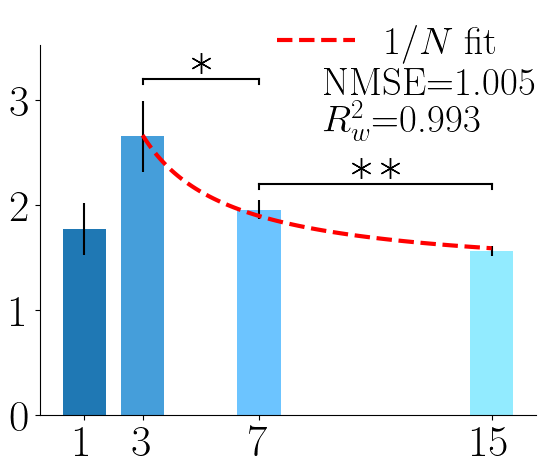

In [50]:
SpineDir = DatDir+'/1Spine/'
mt= LoadOneSpine(SpineDir,True)
mt1 = np.copy(mt)
d1 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mt[3:,i],maxfev=5000)[0][1] for i in range(mt.shape[1])])

SpineDir = DatDir+'3Spine/'
m,_ = LoadThreeSpine(SpineDir,True)
mtot = np.hstack(m)
mtot3 = np.copy(mtot)
d3 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mtot3[3:,i],maxfev=5000)[0][1] for i in range(mtot3.shape[1])])

SpineDir = DatDir+'7Spine/'
m,_ = LoadSevenSpine(SpineDir,True)
mtot = np.hstack(m)
mtot7 = np.copy(mtot)
d7 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mtot7[3:,i],maxfev=5000)[0][1] for i in range(mtot7.shape[1])])

SpineDir = DatDir+'15Spine/'
m,_ = Load15Spine(SpineDir,True)
mtot = np.hstack(m)
mtot15 = np.copy(mtot)
d15 = np.array([sp.optimize.curve_fit(expfunc,[2,10,20,30,40],mtot15[3:,i],maxfev=5000)[0][1] for i in range(mtot15.shape[1])])

plt.bar([1],np.mean(mt1[3]),yerr=stats.sem(mt1[3]),color=C[ColorDict['Control']],width=1.5)
plt.bar([3],np.mean(mtot3[3]),yerr=stats.sem(mtot3[3]),color=np.clip(C[ColorDict['Control']]+0.15,0,1),width=1.5)
plt.bar([7],np.mean(mt7[:,3]),yerr=stats.sem(mt7[:,3]),color=np.clip(C[ColorDict['Control']]+0.3,0,1),width=1.5)
plt.bar([15],np.mean(mtot15[3]),yerr=stats.sem(mtot15[3]),color=np.clip(C[ColorDict['Control']]+0.45,0,1),width=1.5)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

PlotSig(3,7,3.2,0.15)

PlotSig(7,15,2.2,0.15,stars=2,starpad=0.5)
ax.set_xticks([1,3,7,15],[1,3,7,15],fontsize=32)
plt.plot(np.linspace(3,15,100),func(np.linspace(3,15,100),4.03624379, 1.3170679),lw=3,c='r',
         label=r'1/$N$ fit',ls='--')
leg = ax.legend(framealpha=0.0,fontsize=28,loc=1,bbox_to_anchor=(1.0,1.15),frameon=False)
plt.text(9.2,3.05,'NMSE=1.005',fontsize=28)
plt.text(9.2,2.7,'$R_w^2$=0.993',fontsize=28)

### g

In [51]:
xt = [1]*len(mt1[3])+[3]*len(mtot3[3])+[7]*len(mt7[:,3])+len(mtot15[3])*[15]

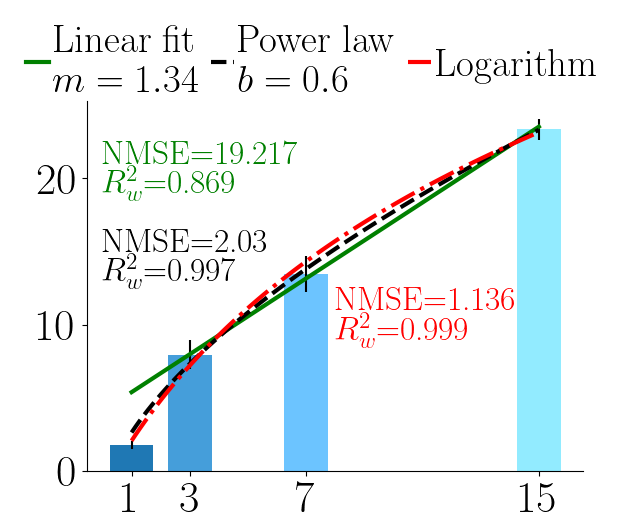

In [52]:
x = np.linspace(1,15,100)
plt.bar([1],(np.mean(mt1[3])),yerr=stats.sem(mt1[3]),color=C[ColorDict['Control']],width=1.5)
plt.bar([3],(np.mean(mtot3[3])*3),yerr=stats.sem(mtot3[3])*3,color=np.clip(C[ColorDict['Control']]+0.15,0,1),width=1.5)
plt.bar([7],(np.mean(mtot7[3])*7),yerr=stats.sem(mtot7[3])*7,color=np.clip(C[ColorDict['Control']]+0.3,0,1),width=1.5)
plt.bar([15],(np.mean(mtot15[3])*15),yerr=stats.sem(mtot15[3])*15,color=np.clip(C[ColorDict['Control']]+0.45,0,1),width=1.5)
plt.plot(x,x*1.2965700063057903 +4.087025158598552,'g',lw=3,label='Linear fit \n $m = 1.34$')
plt.plot(x,powerfunc(x,4.9399    ,  0.60805466, -2.31358832),'k',ls='--',lw=3,label='Power law \n $b = 0.6$')
plt.plot(x,logfunc(x,16.8554549 ,  0.20146472,  0.92877397),'r',lw=3,ls='-.',label='Logarithm')

plt.xticks([1,3,7,15])
plt.legend(frameon=False,ncol=3,loc = 1,bbox_to_anchor=(1.1,1.3),fontsize=28,columnspacing=0.3,handlelength=0.6,handletextpad=0.1)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.text(0,21,'NMSE=19.217',fontsize=24,c='g')
plt.text(0,19,'$R_w^2$=0.869',fontsize=24,c='g')

plt.text(0,15,'NMSE=2.03',fontsize=24,c='k')
plt.text(0,13,'$R_w^2$=0.997',fontsize=24,c='k')

plt.text(8,11,'NMSE=1.136',fontsize=24,c='r')
plt.text(8,9,'$R_w^2$=0.999',fontsize=24,c='r')

### h

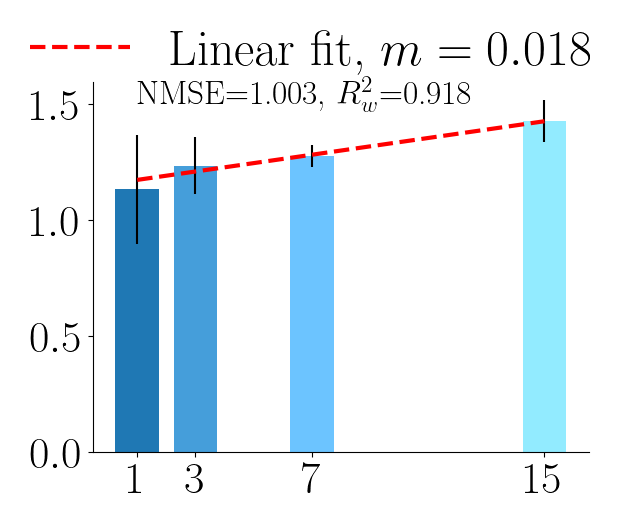

In [56]:
plt.bar([1],np.mean(mt1[-1]),yerr=stats.sem(mt1[-1]),color=C[ColorDict['Control']],width=1.5)
plt.bar([3],np.mean(mtot3[-1]),yerr=stats.sem(mtot3[-1]),color=C[ColorDict['Control']]+0.15,width=1.5)
plt.bar([7],np.mean(mt7[:,-1]),yerr=stats.sem(mt7[:,-1]),color=np.clip(C[ColorDict['Control']]+0.3,0,1),width=1.5)
plt.bar([15],np.mean(mtot15[-1]),yerr=stats.sem(mtot15[-1]),color=np.clip(C[ColorDict['Control']]+0.45,0,1),width=1.5)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([1,3,7,15],[1,3,7,15])
plt.plot([1,3,7,15],np.array([1,3,7,15])*0.018058072428889665+1.154027396017596,lw=3,c='r',ls='--',
        label='Linear fit, $m = 0.018$')
leg = ax.legend(framealpha=0.5,fontsize=36,loc=4,bbox_to_anchor=(1.1,0.9),frameon=False)
plt.text(1,1.5,'NMSE=1.003, $R_w^2$=0.918',fontsize=24)


## Supplemental figure 1

In [57]:
params =  [1.63241027e-03, 1.05057645e+00, 4.79773558e-03,1.20091169e+00,
     1.19406065e-01, 4.49843716e-02 , 0.2 ,2.01143310e+00,
     10, 1.00000000e+00,0.28093303e+00, 2.07116490e+00,
     3.01751859e+00, 7.94972648e+00] #3.3 works with rho (one) and C (seven)

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_three = np.array([[-0.19,0,0.19],[0,0,0]])

SpineWidth = 1000
SM32 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM32.Simulate()
xvec = SM32.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]


### a

In [58]:
params =  [1.63241027e-03, 1.05057645e+00, 4.79773558e-03,1.20091169e+00,
     1.19406065e-01, 4.49843716e-02 , 0.2 ,2.01143310e+00,
     10, 1.00000000e+00,0.28093303e+00, 2.07116490e+00,
     3.01751859e+00, 7.94972648e+00] #3.3 works with rho (one) and C (seven)

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_three = np.array([[-0.19,0,0.19],[0,0,0]])

SpineWidth = 1000
SM32 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM32.Simulate()
xvec = SM32.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]


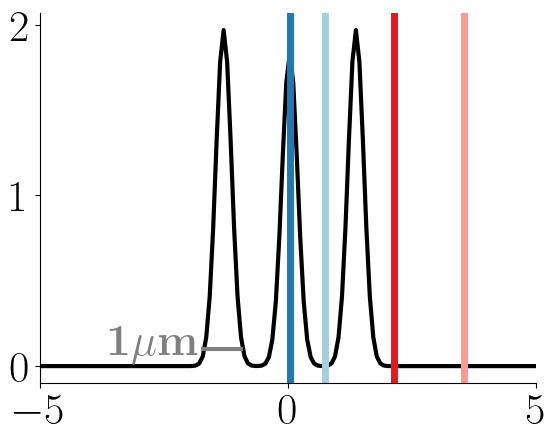

In [59]:
xmu = np.linspace(-14,14,400)
plt.plot(xmu,SM3.C_tot[0,:],lw=3,c='k',label='Init. C')

plt.axvline(xmu[200],lw=5,label='Stimulated spine')
plt.axvline(xmu[210],lw=5,c=C[ColorDict['Control']-1],label='Inside cluster')
plt.axvline(xmu[230],lw=5,c=C[ColorDict['CHX']],label='Outside cluster')
plt.axvline(xmu[250],lw=5,c=C[ColorDict['CHX']-1],label='Away from cluster')
plt.xlim([-5,5])
plt.plot([xmu[175],xmu[186]],[0.1,0.1],c='gray',lw=3)
plt.text(xmu[148],0.06,r'\bf{1}$\mathbf{\mu m}$',color='gray',fontsize=32)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### b

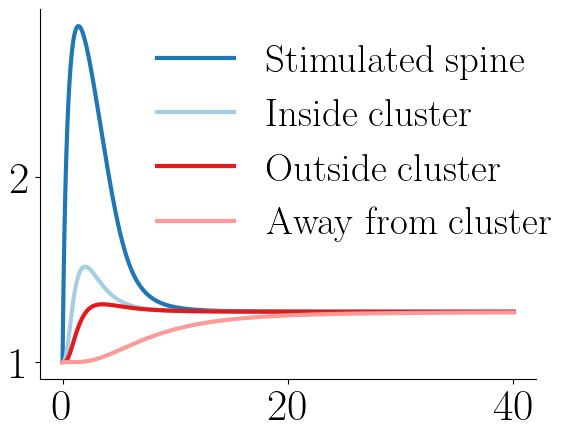

In [60]:
plt.plot(SM3.tvec,SM3.S_tot[:,200],c=C[ColorDict['Control']],lw=3,label='Stimulated spine')
plt.plot(SM3.tvec,SM3.S_tot[:,190],c=C[ColorDict['Control']-1],lw=3,label='Inside cluster')
plt.plot(SM3.tvec,SM3.S_tot[:,170],c=C[ColorDict['CHX']],lw=3,label='Outside cluster')
plt.plot(SM3.tvec,SM3.S_tot[:,150],c=C[ColorDict['CHX']-1],lw=3,label='Away from cluster')
ax = plt.gca()
leg = ax.legend(framealpha=0.5,fontsize=28,loc=1,bbox_to_anchor=(1.1,1.0))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([1,2],[1,2])

### c

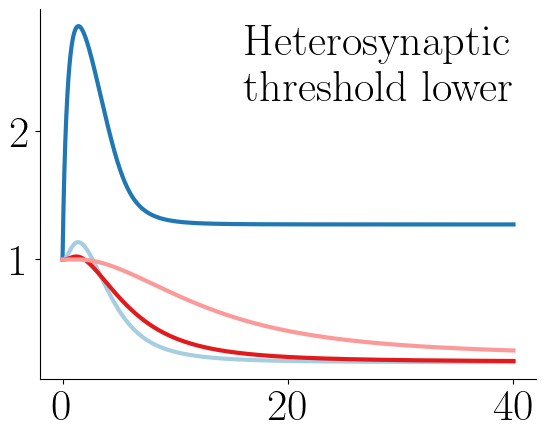

In [61]:
plt.plot(SM3.tvec,SM3.S_tot[:,200],c=C[ColorDict['Control']],lw=3)
plt.plot(SM3.tvec,SM32.S_tot[:,190],c=C[ColorDict['Control']-1],lw=3)
plt.plot(SM3.tvec,SM32.S_tot[:,170],c=C[ColorDict['CHX']],lw=3)
plt.plot(SM3.tvec,SM32.S_tot[:,150],c=C[ColorDict['CHX']-1],lw=3)
plt.text(28,2.5,'Heterosynaptic \n threshold lower',ha='center', va='center',fontsize=32)
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### d

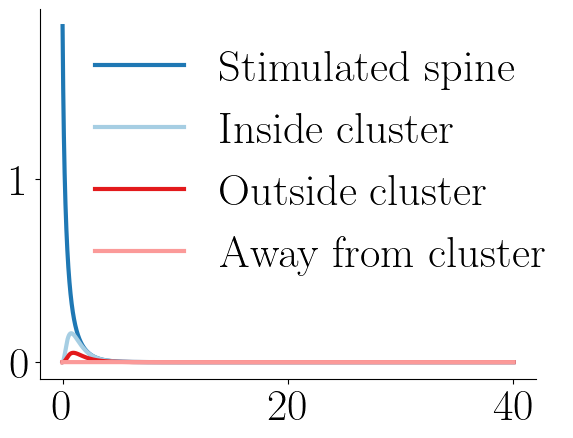

In [62]:
plt.plot(SM3.tvec,SM3.C_tot[:,200],c=C[ColorDict['Control']],lw=3,label='Stimulated spine')
plt.plot(SM3.tvec,SM3.C_tot[:,190],c=C[ColorDict['Control']-1],lw=3,label='Inside cluster')
plt.plot(SM3.tvec,SM3.C_tot[:,170],c=C[ColorDict['CHX']],lw=3,label='Outside cluster')
plt.plot(SM3.tvec,SM3.C_tot[:,150],c=C[ColorDict['CHX']-1],lw=3,label='Away from cluster')
ax = plt.gca()
leg = ax.legend(framealpha=0.5,fontsize=32,loc=1,bbox_to_anchor=(1.1,1.0))
leg.get_frame().set_linewidth(0.0)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### e

Text(28, -0.02, 'Unchanged \n parameters')

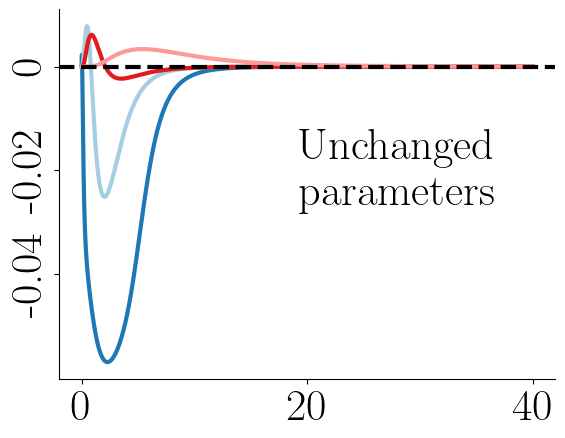

In [63]:
plt.plot(SM3.tvec,SM3.P_tot[:,200]*SM3.F(SM3.S_tot[:,200]),c=C[ColorDict['Control']],lw=3)
plt.plot(SM3.tvec,SM3.P_tot[:,190]*SM3.F(SM3.S_tot[:,190]),c=C[ColorDict['Control']-1],lw=3)
plt.plot(SM3.tvec,SM3.P_tot[:,170]*SM3.F(SM3.S_tot[:,170]),c=C[ColorDict['CHX']],lw=3)
plt.plot(SM3.tvec,SM3.P_tot[:,150]*SM3.F(SM3.S_tot[:,150]),c=C[ColorDict['CHX']-1],lw=3)
plt.axhline(0,lw=3,c='k',ls='--')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([0,-0.02,-0.04],[0,-0.02,-0.04],rotation=90,va='center')
plt.text(28,-0.02,'Unchanged \n parameters',ha='center', va='center',fontsize=32)

### f

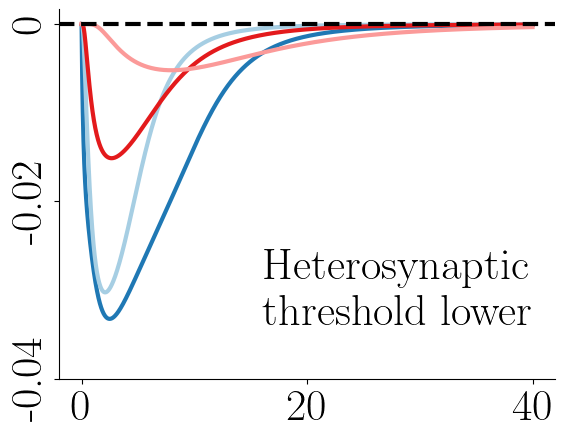

In [64]:
plt.plot(SM3.tvec,SM32.P_tot[:,200]*SM32.F(SM32.S_tot[:,200]),c=C[ColorDict['Control']],lw=3)
plt.plot(SM3.tvec,SM32.P_tot[:,190]*SM32.F(SM32.S_tot[:,190]),c=C[ColorDict['Control']-1],lw=3)
plt.plot(SM3.tvec,SM32.P_tot[:,170]*SM32.F(SM32.S_tot[:,170]),c=C[ColorDict['CHX']],lw=3)
plt.plot(SM3.tvec,SM32.P_tot[:,150]*SM32.F(SM32.S_tot[:,150]),c=C[ColorDict['CHX']-1],lw=3)
plt.text(28,-0.03,'Heterosynaptic \n threshold lower',ha='center', va='center',fontsize=32)
plt.axhline(0,lw=3,c='k',ls='--')
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_yticks([0,-0.02,-0.04],[0,-0.02,-0.04],rotation=90,va='center')

### g

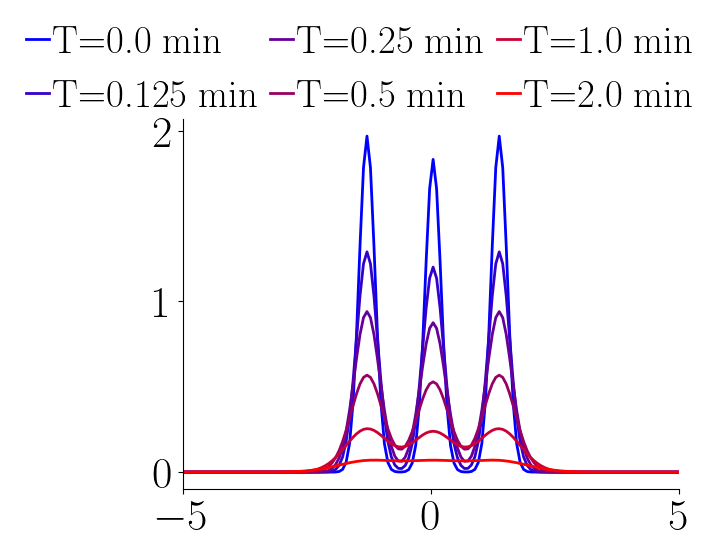

In [65]:
params = np.load(DatDir+'ModelFit/ControlFit3.npy')

a1 = params[0]
a2 = params[1]

b1 = params[2]
b2 =  params[3]
rho = params[4]
gamma = params[5]

nu = params[6]
phi = params[7]

lam = params[8]
mu  = params[9] 
Cs  = params[10]
Cd  = params[11]

zeta1 = params[12]
zeta2 = params[13]

tMax  = 40
xMax  = 2

times = [2,10,20,30,40]
stims_three = np.array([[-0.13,0,0.13],[0,0,0]])

SpineWidth = 1000
SM3 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM3.Simulate()
xvec = SM3.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]

Min3_m = SM3.S_tot[:,stimlocs_three[1]]
Min3_e = SM3.S_tot[:,stimlocs_three[0]]

stims_three = np.array([[-0.25,0,0.25],[0,0,0]])

SpineWidth = 1000
SM3 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM3.Simulate()
xvec = SM3.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]

Max3_m = SM3.S_tot[:,stimlocs_three[1]]
Max3_e = SM3.S_tot[:,stimlocs_three[0]]

stims_three = np.array([[-0.19,0,0.19],[0,0,0]])

SpineWidth = 1000
SM3 = SpatialModel([a1,a2],[b1,b2,rho],gamma,[zeta1,zeta2],[nu,phi],[lam,mu,Cs,Cd],tMax,xMax,stims_three)
SM3.Simulate()
xvec = SM3.x.round(2)
stimlocs_three = [np.argwhere(xvec == s)[0,0] for s in stims_three[0]]

Mid3_m = SM3.S_tot[:,stimlocs_three[1]]
Mid3_e = SM3.S_tot[:,stimlocs_three[0]]


k=0
plt.plot(xmu,SM3.C_tot[k,:],lw=2,c=[0,0,1],label='T='+str(SM3.tvec[0])+' min')
k=50
plt.plot(xmu,SM3.C_tot[k,:],lw=2,c=[0.2,0,0.8],label='T='+str(SM3.tvec[50])+' min')
k=100
plt.plot(xmu,SM3.C_tot[k,:],lw=2,c=[0.4,0,0.6],label='T='+str(SM3.tvec[100])+' min')
k=200
plt.plot(xmu,SM3.C_tot[k,:],lw=2,c=[0.6,0,0.4],label='T='+str(SM3.tvec[200])+' min')
k=400
plt.plot(xmu,SM3.C_tot[k,:],lw=2,c=[0.8,0,0.2],label='T='+str(SM3.tvec[400])+' min')
k=800
plt.plot(xmu,SM3.C_tot[k,:],lw=2,c=[1.0,0,0.0],label='T='+str(SM3.tvec[800])+' min')
plt.xlim([-5,5])
plt.legend(frameon=False,ncols=3,fontsize=28,columnspacing=0.3,handlelength=0.6,handletextpad=0.1,loc=1,bbox_to_anchor=(1.1,1.35))

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

### h

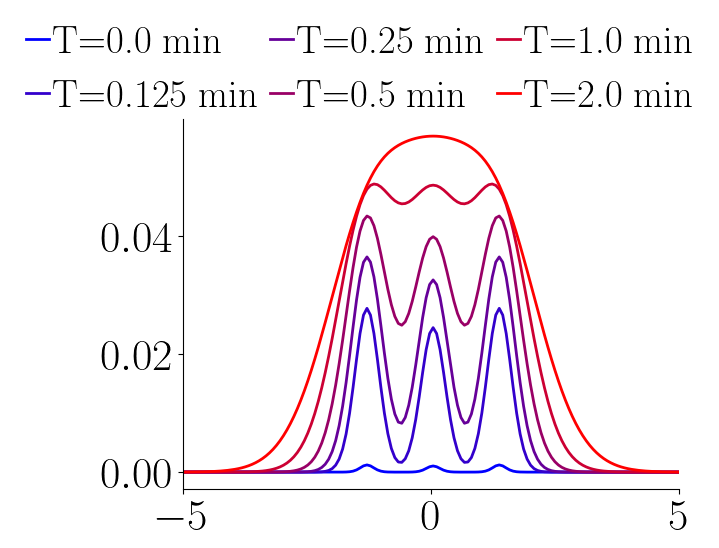

In [66]:
k=0
plt.plot(xmu,SM3.P_tot[k,:],lw=2,c=[0,0,1],label='T='+str(SM3.tvec[0])+' min')
k=50
plt.plot(xmu,SM3.P_tot[k,:],lw=2,c=[0.2,0,0.8],label='T='+str(SM3.tvec[50])+' min')
k=100
plt.plot(xmu,SM3.P_tot[k,:],lw=2,c=[0.4,0,0.6],label='T='+str(SM3.tvec[100])+' min')
k=200
plt.plot(xmu,SM3.P_tot[k,:],lw=2,c=[0.6,0,0.4],label='T='+str(SM3.tvec[200])+' min')
k=400
plt.plot(xmu,SM3.P_tot[k,:],lw=2,c=[0.8,0,0.2],label='T='+str(SM3.tvec[400])+' min')
k=800
plt.plot(xmu,SM3.P_tot[k,:],lw=2,c=[1.0,0,0.0],label='T='+str(SM3.tvec[800])+' min')
plt.xlim([-5,5])
plt.legend(frameon=False,ncols=3,fontsize=28,columnspacing=0.3,handlelength=0.6,handletextpad=0.1,loc=1,bbox_to_anchor=(1.1,1.35))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.savefig('/Users/maximilianeggl/Dropbox/PostDoc/Rebuttal2Figs/Review/Figures/PDistDiff.pdf',
            format='pdf',bbox_inches='tight')

In [69]:
b = np.array([0,0,1])
r = np.array([1,0,0])

# Supplemental Figure 2

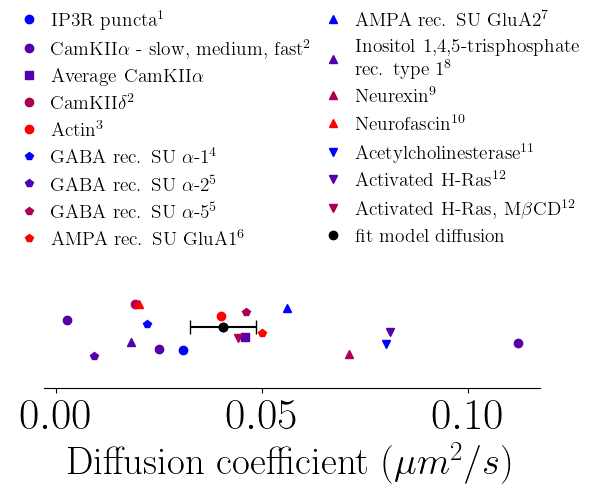

In [78]:
np.random.seed(43)


plt.plot(0.0308,(np.random.rand()-0.5)/100,'o',c =b, label = 'IP3R puncta$^1$')

plt.plot(0.0025,(np.random.rand()-0.5)/100,'o', c =  b*0.67 + r*0.33,label=r'CamKII$\alpha$ - slow, medium, fast$^2$')
plt.plot(0.025,(np.random.rand()-0.5)/100,'o',c =  b*0.67 + r*0.33)
plt.plot(0.112,(np.random.rand()-0.5)/100,'o',c =  b*0.67 + r*0.33)
plt.plot(0.0458,(np.random.rand()-0.5)/100,'s',c =  b*0.67 + r*0.33,label=r'Average CamKII$\alpha$')
plt.plot(0.019,(np.random.rand()-0.5)/100,'o',c =  b*0.33 + r*0.67,label=r'CamKII$\delta^2$')




plt.plot(0.04,(np.random.rand()-0.5)/100,'o',color=r,label='Actin$^3$')


plt.plot(0.022,(np.random.rand()-0.5)/100,'p',c = b,label=r'GABA rec. SU $\alpha$-1$^4$')
plt.plot(0.009,(np.random.rand()-0.5)/100,'p',c = b*0.67 + r*0.33,label=r'GABA rec. SU $\alpha$-2$^5$')
plt.plot(0.046,(np.random.rand()-0.5)/100,'p',c = b*0.33 + r*0.67,label=r'GABA rec. SU $\alpha$-5$^5$')

plt.plot(0.05,(np.random.rand()-0.5)/100,'p',c = r,label='AMPA rec. SU GluA1$^6$')
plt.plot(0.056,(np.random.rand()-0.5)/100,'^',c = b,label='AMPA rec. SU GluA2$^7$')

plt.plot(0.018,(np.random.rand()-0.5)/100,'^',c = b*0.67 + r*0.33,label='Inositol 1,4,5-trisphosphate \n rec. type 1$^8$') # 
plt.plot(0.071,(np.random.rand()-0.5)/100,'^',color=b*0.33 + r*0.67,label='Neurexin$^9$') # Nrxn
plt.plot(0.02,(np.random.rand()-0.5)/100,'^',color=r,label='Neurofascin$^{10}$')

plt.plot(0.08,(np.random.rand()-0.5)/100,'v',color=b,label='Acetylcholinesterase$^{11}$')

plt.plot(0.081,(np.random.rand()-0.5)/100,'v',color=b*0.67 + r*0.33,label='Activated H-Ras$^{12}$')
plt.plot(0.044,(np.random.rand()-0.5)/100,'v',color=b*0.33 + r*0.67,label=r'Activated H-Ras, M$\beta$CD$^{12}$')

plt.errorbar([b1*(1.6/0.19)], [0], xerr=[b1*(1.6/0.19)*0.2],capsize=5,c='k',marker='o')

plt.plot([b1*(1.6/0.19)], [0],'ok',label='fit model diffusion')

plt.ylim([-0.01,0.05])
plt.legend(ncols=2,frameon=False,handletextpad=0.1,columnspacing=0.1,borderpad=0.0,loc = 1,bbox_to_anchor=(1.1,1.05))
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.yticks([])
plt.xlabel('Diffusion coefficient ($\mu m^2 /s)$',fontsize=28)


# Supplemental Figure 3

In [9]:
Calc = pd.read_excel(DatDir+'Calcium/2024_3_5 Calcium imaging data for Max.xlsx')

In [10]:
S1 = np.array(Calc['1x spine'])
S1sem = np.array(Calc['s.e.m.'])

S3 = np.array(Calc['3x spine'])
S3sem = np.array(Calc['s.e.m..2'])

S7 = np.array(Calc['7x spine'])
S7sem = np.array(Calc['s.e.m..4'])

S15 = np.array(Calc['15x spine'])
S15sem = np.array(Calc['s.e.m..6'])

S7d = np.array(Calc['7x distributed spine'])
S7dsem = np.array(Calc['s.e.m..8'])

S1d = np.array(Calc['1x dendrite'])
S1semd = np.array(Calc['s.e.m..1'])

S3d = np.array(Calc['3x dendrite'])
S3semd = np.array(Calc['s.e.m..3'])

S7d = np.array(Calc['7x dendrite'])
S7semd = np.array(Calc['s.e.m..5'])

S15d = np.array(Calc['15x dendrite'])
S15semd = np.array(Calc['s.e.m..7'])

S7dd = np.array(Calc['7x distributed dendrite'])
S7dsemd = np.array(Calc['s.e.m..9'])



## b

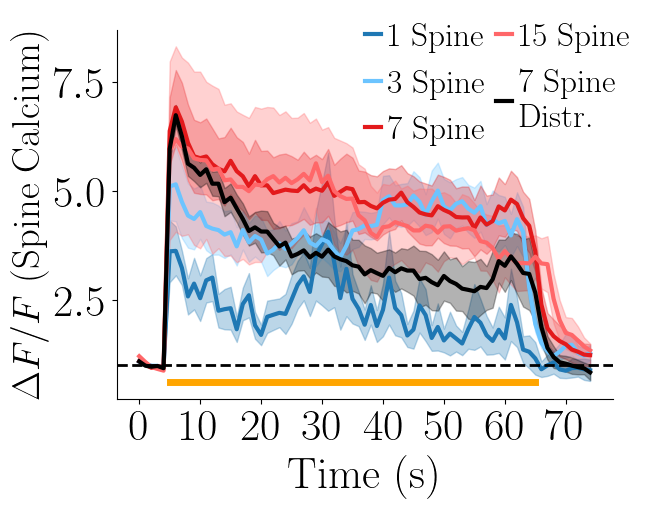

In [11]:
plt.fill_between(x = np.arange(75),y1=S1+S1sem,y2 = S1-S1sem,alpha=0.3,color=C[ColorDict['Control']])
plt.plot(np.arange(75),S1,color=C[ColorDict['Control']],label='1 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S3+S3sem,y2 = S3-S3sem,alpha=0.3,color=np.clip(C[ColorDict['Control']]+0.3,0,1))
plt.plot(np.arange(75),S3,color=np.clip(C[ColorDict['Control']]+0.3,0,1),label='3 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S7+S7sem,y2 = S7-S7sem,alpha=0.3,color=C[ColorDict['CHX']])
plt.plot(np.arange(75),S7,color=C[ColorDict['CHX']],label='7 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S15+S15sem,y2 = S15-S15sem,alpha=0.3,color=np.clip(C[ColorDict['CHX']]+0.3,0,1))
plt.plot(np.arange(75),S15,color=np.clip(C[ColorDict['CHX']]+0.3,0,1),label='15 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S7d+S7dsem,y2 = S7d-S7dsem,alpha=0.3,color='k')
plt.plot(np.arange(75),S7d,'k',label='7 Spine \n Distr.',lw=3)
plt.legend(frameon=False,ncols=2,fontsize=24,columnspacing=0.3,handlelength=0.5,handletextpad=0.2,loc=1,bbox_to_anchor=(1.1,1.1))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([-10,0,10,20,30,40,50,60,70,80])
plt.plot([5,65],[0.6,0.6],c='orange',lw=5)
plt.xlabel('Time (s)',fontsize=32)
plt.ylabel('$\Delta F/ F$ (Spine Calcium)',fontsize=28)
plt.axhline(1,lw=2,c='k',ls='dashed')

## c

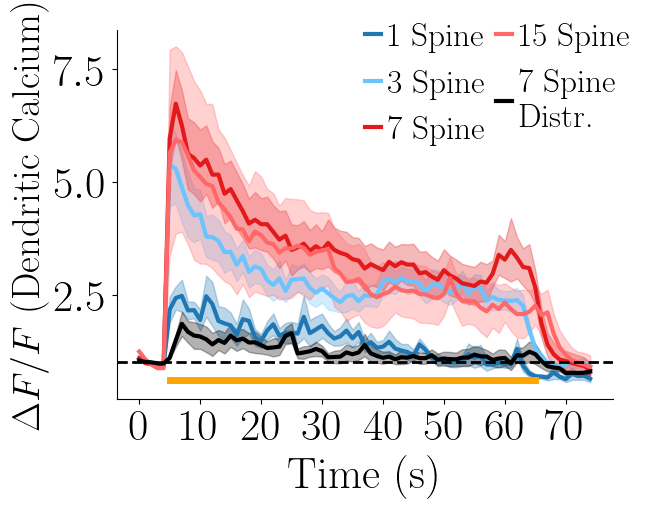

In [12]:
plt.fill_between(x = np.arange(75),y1=S1d+S1semd,y2 = S1d-S1semd,alpha=0.3,color=C[ColorDict['Control']])
plt.plot(np.arange(75),S1d,color=C[ColorDict['Control']],label='1 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S3d+S3semd,y2 = S3d-S3semd,alpha=0.3,color=np.clip(C[ColorDict['Control']]+0.3,0,1))
plt.plot(np.arange(75),S3d,color=np.clip(C[ColorDict['Control']]+0.3,0,1),label='3 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S7d+S7semd,y2 = S7d-S7semd,alpha=0.3,color=C[ColorDict['CHX']])
plt.plot(np.arange(75),S7d,color=C[ColorDict['CHX']],label='7 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S15d+S15semd,y2 = S15d-S15semd,alpha=0.3,color=np.clip(C[ColorDict['CHX']]+0.3,0,1))
plt.plot(np.arange(75),S15d,color=np.clip(C[ColorDict['CHX']]+0.3,0,1),label='15 Spine',lw=3)
plt.fill_between(x = np.arange(75),y1=S7dd+S7dsemd,y2 = S7dd-S7dsemd,alpha=0.3,color='k')
plt.plot(np.arange(75),S7dd,'k',label='7 Spine \n Distr.',lw=3)
plt.legend(frameon=False,ncols=2,fontsize=24,columnspacing=0.3,handlelength=0.5,handletextpad=0.2,loc=1,bbox_to_anchor=(1.1,1.1))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_xticks([-10,0,10,20,30,40,50,60,70,80])
plt.plot([5,65],[0.6,0.6],c='orange',lw=5)
plt.xlabel('Time (s)',fontsize=32)
plt.ylabel('$\Delta F/ F$ (Dendritic Calcium)',fontsize=28)
plt.axhline(1,lw=2,c='k',ls='dashed')

## d

In [13]:
Calc2 = pd.read_excel(
    DatDir+'Calcium/2024_3_5 Calcium imaging data for Max.xlsx',
    sheet_name='Spatial calcium profiles')

In [14]:
S1 = np.array(Calc2['1x'])
S1sem = np.array(Calc2['s.e.m.'])
S1dist = np.array(Calc2['Distance'])

S3 = np.array(Calc2['3x'])
S3sem = np.array(Calc2['s.e.m..1'])
S3dist = np.array(Calc2['Distance.1'])

S7 = np.array(Calc2['7x'])
S7sem = np.array(Calc2['s.e.m..2'])
S7dist = np.array(Calc2['Distance.2'])

S15 = np.array(Calc2['15x'])
S15sem = np.array(Calc2['s.e.m..3'])
S15dist = np.array(Calc2['Distance.3'])

S7d = np.array(Calc2['7x distributed'])
S7dsem = np.array(Calc2['s.e.m..4'])
S7ddist = np.array(Calc2['Distance.4'])

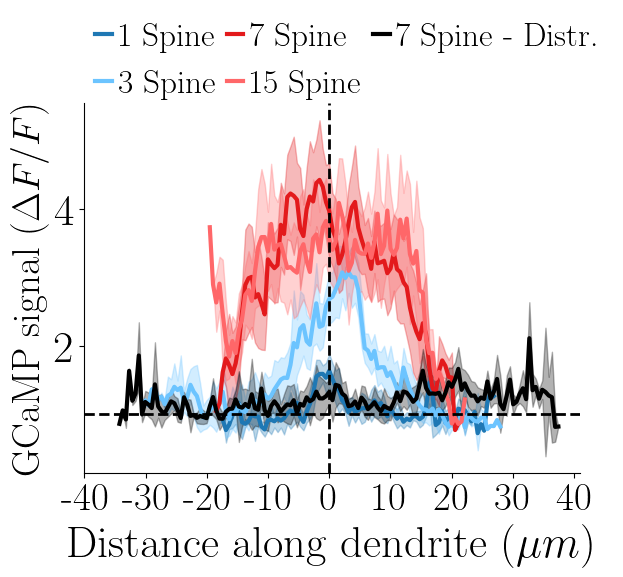

In [15]:
plt.fill_between(x =S1dist,y1=S1+S1sem,y2 = S1-S1sem,alpha=0.3,color=C[ColorDict['Control']])
plt.plot(S1dist,S1,color=C[ColorDict['Control']],label='1 Spine',lw=3)
plt.fill_between(x = S3dist,y1=S3+S3sem,y2 = S3-S3sem,alpha=0.3,color=np.clip(C[ColorDict['Control']]+0.3,0,1))
plt.plot(S3dist,S3,color=np.clip(C[ColorDict['Control']]+0.3,0,1),label='3 Spine',lw=3)
plt.fill_between(x = S7dist,y1=S7+S7sem,y2 = S7-S7sem,alpha=0.3,color=C[ColorDict['CHX']])
plt.plot(S7dist,S7,color=C[ColorDict['CHX']],label='7 Spine',lw=3)
plt.fill_between(x = S15dist,y1=S15+S15sem,y2 = S15-S15sem,alpha=0.3,color=np.clip(C[ColorDict['CHX']]+0.3,0,1))
plt.plot(S15dist,S15,color=np.clip(C[ColorDict['CHX']]+0.3,0,1),label='15 Spine',lw=3)
plt.fill_between(x = S7ddist,y1=S7d+S7dsem,y2 = S7d-S7dsem,alpha=0.3,color='k')
plt.plot(S7ddist,S7d,'k',label='7 Spine - Distr.',lw=3)
plt.legend(frameon=False,ncols=3,fontsize=24,columnspacing=0.3,handlelength=0.5,handletextpad=0.2,loc=1,bbox_to_anchor=(1.1,1.3))
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.xticks([-40,-30,-20,-10,0,10,20,30,40],[-40,-30,-20,-10,0,10,20,30,40],fontsize=28)
plt.xlabel('Distance along dendrite ($\mu m$)',fontsize=32)
plt.ylabel('GCaMP signal ($\Delta F/ F$)',fontsize=28)
plt.axhline(1,lw=2,c='k',ls='dashed')
plt.axvline(0,lw=2,c='k',ls='dashed')